<a href="https://colab.research.google.com/github/bennguyen99/TheLook-Ecommerce-Analytics-China-2019-2023-/blob/main/TheLook-China-Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Introduction

* **Purpose**: This project analyzes TheLook's sales data in China from 2019 to 2023 to identify key trends, evaluate returned rates, and assess product performance across regions, and customer segments. The goal is to generate actionable insights to improve product offerings, optimize sales operation, and enhance marketing strategies.

* **Dataset Overview**: This project uses **five primary datasets**:

    * `order_items.csv`: This dataset contains individual order records, including purchase timestamps, product id, customer id, and order status. It provides the foundation for analyzing sales trends, customer loyalty, and returned rates across various dimensions.

    * `inventory_items.csv`: The dataset offers comprehensive details on all inventory items in TheLook’s distribution centers, encompassing product information, purchase timestamps, costs, and sale prices. This enables analysis of profitability and product-level margin performance.

    * `user.csv`: Includes customer demographic data such as age, gender, and location, along with account creation dates. This dataset facilitates customer segmentation, lifetime value (LTV) analysis, and personalized marketing strategies.

    * `distribution_centers.csv`: Details the locations and order volumes of TheLook’s distribution centers. It is essential for identifying demand distribution, setting accurate reorder points, and optimizing supply chain efficiency.

    * `events.csv`: This dataset provides additional geographic context for each order, linking country codes to regions. It enables regional analysis.
    
  Together, these datasets provide a holistic view of sales performance, customer behavior, and regional trends.

<br>

   **An overlook of the dataset**

![[CS] ERD (1).jpg](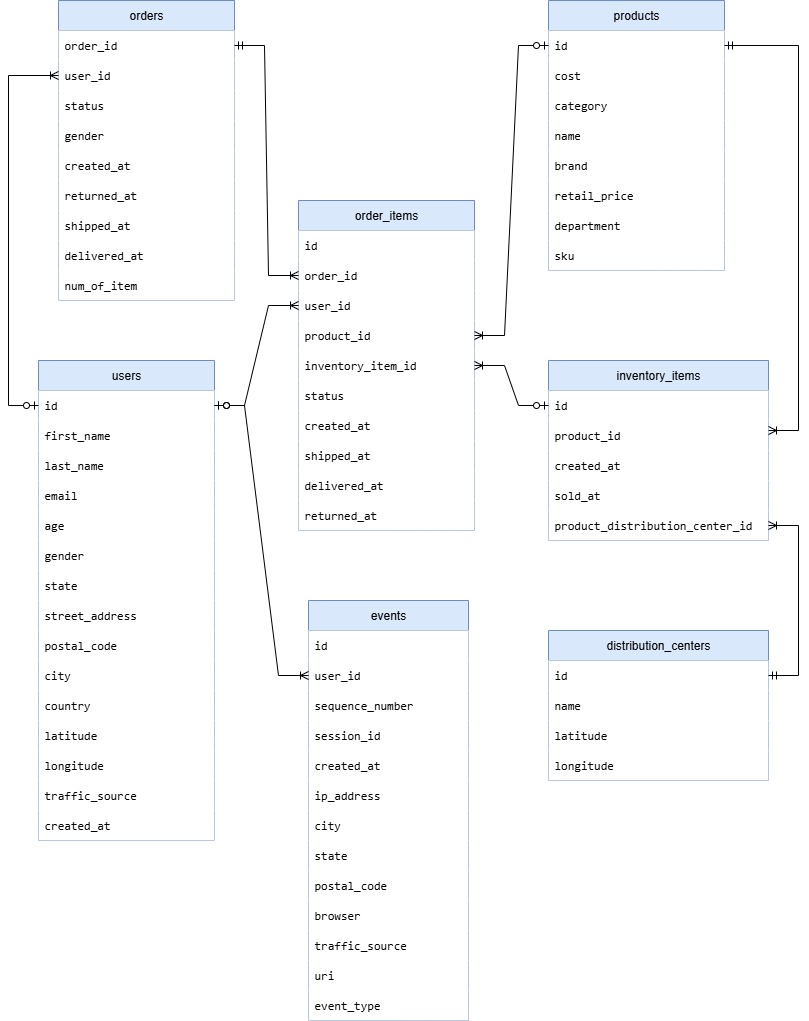)

# II. Import datasets

Load and examine the initial structure of the datasets required for this analysis.

In [2]:
%pip install gdown
import gdown
import pandas as pd
# Read CSV files
csv_files = {
    "distribution_centers": "1_Embm0cVwE55426G0JuN_3lFZRbEZrHA",
    "events": "1DjBdZTZgW0L8zudFRSHE64KkIHMX0ixl",
    "inventory_items": "1Pqe_iX6X9izBh-ZKj0PjSZ5uL2CV3z-G",
    "order_items": "135fMm2p5dj_9YvbQ9UoCps0Zj08k6T55",
    "orders": "14THuLHh_Sz8Fx9v9C3U0ml2BHNPseWYy",
    "products": "1gXYhDKUIdYhFLcu4vjPxCuB-KMd3uHTV",
    "users": "1K-wwUIKB76vba13i43EIVDAZZjA8zp6E"
}

for var_name, file_id in csv_files.items():
    output = f"{var_name}.csv"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)
    globals()[var_name] = pd.read_csv(output)


Downloading...
From: https://drive.google.com/uc?id=1_Embm0cVwE55426G0JuN_3lFZRbEZrHA
To: /content/distribution_centers.csv
100%|██████████| 369/369 [00:00<00:00, 937kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1DjBdZTZgW0L8zudFRSHE64KkIHMX0ixl
From (redirected): https://drive.google.com/uc?id=1DjBdZTZgW0L8zudFRSHE64KkIHMX0ixl&confirm=t&uuid=41e5af95-0a92-45aa-a11b-89d5ec95972e
To: /content/events.csv
100%|██████████| 394M/394M [00:04<00:00, 98.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Pqe_iX6X9izBh-ZKj0PjSZ5uL2CV3z-G
To: /content/inventory_items.csv
100%|██████████| 93.9M/93.9M [00:01<00:00, 75.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=135fMm2p5dj_9YvbQ9UoCps0Zj08k6T55
To: /content/order_items.csv
100%|██████████| 19.9M/19.9M [00:00<00:00, 49.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=14THuLHh_Sz8Fx9v9C3U0ml2BHNPseWYy
To: /content/orders.csv
100%|██████████| 10.3M/10.3M [00:00<00:00, 29.2MB/s]
Downloading...
Fr

In [3]:
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.ticker as ticker
import math
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import textwrap
from google.colab import files

In [4]:
distribution_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10 non-null     int64  
 1   name       10 non-null     object 
 2   latitude   10 non-null     float64
 3   longitude  10 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 452.0+ bytes


In [5]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431963 entries, 0 to 2431962
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   user_id          float64
 2   sequence_number  int64  
 3   session_id       object 
 4   created_at       object 
 5   ip_address       object 
 6   city             object 
 7   state            object 
 8   postal_code      object 
 9   browser          object 
 10  traffic_source   object 
 11  uri              object 
 12  event_type       object 
dtypes: float64(1), int64(2), object(10)
memory usage: 241.2+ MB


In [6]:
inventory_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490705 entries, 0 to 490704
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              490705 non-null  int64  
 1   product_id                      490705 non-null  int64  
 2   created_at                      490705 non-null  object 
 3   sold_at                         181759 non-null  object 
 4   cost                            490705 non-null  float64
 5   product_category                490705 non-null  object 
 6   product_name                    490676 non-null  object 
 7   product_brand                   490304 non-null  object 
 8   product_retail_price            490705 non-null  float64
 9   product_department              490705 non-null  object 
 10  product_sku                     490705 non-null  object 
 11  product_distribution_center_id  490705 non-null  int64  
dtypes: float64(2), i

In [7]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181759 entries, 0 to 181758
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 181759 non-null  int64  
 1   order_id           181759 non-null  int64  
 2   user_id            181759 non-null  int64  
 3   product_id         181759 non-null  int64  
 4   inventory_item_id  181759 non-null  int64  
 5   status             181759 non-null  object 
 6   created_at         181759 non-null  object 
 7   shipped_at         118281 non-null  object 
 8   delivered_at       63841 non-null   object 
 9   returned_at        18232 non-null   object 
 10  sale_price         181759 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 15.3+ MB


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125226 entries, 0 to 125225
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   order_id      125226 non-null  int64 
 1   user_id       125226 non-null  int64 
 2   status        125226 non-null  object
 3   gender        125226 non-null  object
 4   created_at    125226 non-null  object
 5   returned_at   12530 non-null   object
 6   shipped_at    81461 non-null   object
 7   delivered_at  43884 non-null   object
 8   num_of_item   125226 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 8.6+ MB


In [9]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  int64  
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              100000 non-null  int64  
 1   first_name      100000 non-null  object 
 2   last_name       100000 non-null  object 
 3   email           100000 non-null  object 
 4   age             100000 non-null  int64  
 5   gender          100000 non-null  object 
 6   state           100000 non-null  object 
 7   street_address  100000 non-null  object 
 8   postal_code     100000 non-null  object 
 9   city            99042 non-null   object 
 10  country         100000 non-null  object 
 11  latitude        100000 non-null  float64
 12  longitude       100000 non-null  float64
 13  traffic_source  100000 non-null  object 
 14  created_at      100000 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 11.4+ MB


Display the first few rows of each dataset to confirm successful loading and inspect initial data structure.

In [11]:
inventory_items.head()

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,67971,13844,2022-07-02 07:09:20+00:00,2022-07-24 06:33:20+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
1,67972,13844,2023-12-20 03:28:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
2,67973,13844,2023-06-04 02:53:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
3,72863,13844,2021-10-16 22:58:52+00:00,2021-11-22 02:19:52+00:00,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7
4,72864,13844,2021-08-07 16:33:00+00:00,NaN,2.76804,Accessories,(ONE) 1 Satin Headband,Funny Girl Designs,6.99,Women,2A3E953A5E3D81E67945BCE5519F84C8,7


In [12]:
order_items.head()

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,152013,104663,83582,14235,410368,Cancelled,2023-05-07 06:08:40+00:00,NaN,NaN,NaN,0.02
1,40993,28204,22551,14235,110590,Complete,2023-03-14 03:47:21+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,NaN,0.02
2,51224,35223,28215,14235,138236,Complete,2023-12-05 13:25:30+00:00,2023-12-06 01:20:00+00:00,2023-12-10 10:04:00+00:00,NaN,0.02
3,36717,25278,20165,14235,99072,Shipped,2023-12-22 20:48:19+00:00,2023-12-24 16:44:00+00:00,NaN,NaN,0.02
4,131061,90241,71954,14235,353798,Shipped,2022-06-19 16:57:59+00:00,2022-06-19 19:29:00+00:00,NaN,NaN,0.02


In [13]:
users.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,457,Timothy,Bush,timothybush@example.net,65,M,Acre,87620 Johnson Hills,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2022-07-19 13:51:00+00:00
1,6578,Elizabeth,Martinez,elizabethmartinez@example.com,34,F,Acre,1705 Nielsen Land,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2023-11-08 18:49:00+00:00
2,36280,Christopher,Mendoza,christophermendoza@example.net,13,M,Acre,125 Turner Isle Apt. 264,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Email,2019-08-24 06:10:00+00:00
3,60193,Jimmy,Conner,jimmyconner@example.com,64,M,Acre,0966 Jose Branch Apt. 008,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2020-02-15 11:26:00+00:00
4,64231,Natasha,Wilson,natashawilson@example.net,25,F,Acre,20798 Phillip Trail Apt. 392,69917-400,Rio Branco,Brasil,-9.945568,-67.83561,Search,2020-03-13 06:45:00+00:00


In [14]:
events.head()

,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,2198523,NaN,3,83889ed2-2adc-4b9a-af5d-154f6998e778,2021-06-17 17:30:00+00:00,138.143.9.202,São Paulo,São Paulo,02675-031,Chrome,Adwords,/cancel,cancel
1,1773216,NaN,3,7a3fc3f2-e84f-44fe-8876-eff76741f7a3,2020-08-07 08:41:00+00:00,85.114.141.79,Santa Isabel,São Paulo,07500-000,Safari,Adwords,/cancel,cancel
2,2380515,NaN,3,13d9b2fb-eee1-43fd-965c-267b38dd7125,2021-02-15 18:48:00+00:00,169.250.255.132,Mairiporã,São Paulo,07600-000,IE,Adwords,/cancel,cancel
3,2250597,NaN,3,96f1d44e-9621-463c-954c-d8deb7fffe7f,2022-03-30 10:56:00+00:00,137.25.222.160,Cajamar,São Paulo,07750-000,Chrome,Adwords,/cancel,cancel
4,1834446,NaN,3,d09dce10-a7cb-47d3-a9af-44975566fa03,2019-09-05 01:18:00+00:00,161.114.4.174,São Paulo,São Paulo,09581-680,Chrome,Email,/cancel,cancel


In [15]:
distribution_centers.head()

,id,name,latitude,longitude
0,1,Memphis TN,35.1174,-89.9711
1,2,Chicago IL,41.8369,-87.6847
2,3,Houston TX,29.7604,-95.3698
3,4,Los Angeles CA,34.0500,-118.2500
4,5,New Orleans LA,29.9500,-90.0667


# III. Data Cleaning

## Data Type Corrections

Convert timestamps from string to their correct format to facilitate time-series analysis

In [16]:
events['user_id'] = events['user_id'].astype('Int64')

In [17]:
order_items['delivered_at'] = pd.to_datetime(order_items['delivered_at'], format='ISO8601',errors='coerce')
order_items['created_at'] = pd.to_datetime(order_items['created_at'], format='ISO8601',errors='coerce')
order_items['shipped_at'] = pd.to_datetime(order_items['shipped_at'], format='ISO8601',errors='coerce')
order_items['returned_at'] = pd.to_datetime(order_items['returned_at'], format='ISO8601',errors='coerce')

In [18]:
orders['delivered_at'] = pd.to_datetime(orders['delivered_at'], format='ISO8601',errors='coerce')
orders['created_at'] = pd.to_datetime(orders['created_at'], format='ISO8601',errors='coerce')
orders['shipped_at'] = pd.to_datetime(orders['shipped_at'], format='ISO8601',errors='coerce')
orders['returned_at'] = pd.to_datetime(orders['returned_at'], format='ISO8601',errors='coerce')

In [19]:
inventory_items['sold_at'] = pd.to_datetime(inventory_items['sold_at'], format='ISO8601',errors='coerce')
inventory_items['created_at'] = pd.to_datetime(inventory_items['created_at'], format='ISO8601',errors='coerce')

In [20]:
users['created_at'] = pd.to_datetime(users['created_at'], format='ISO8601')

## Handling missing values

Create a new column `brand_grouped` where brands with more than 100 products are kept individually, while all others are grouped under "Other".

This preserves total coverage but reduces noise from brands with little representation, ensuring clearer insights in brand-level analysis.

In [21]:
brand_counts = inventory_items['product_brand'].value_counts()
top_brands = brand_counts[brand_counts > 100].index
inventory_items['brand_grouped'] = inventory_items['product_brand'].where(inventory_items['product_brand'].isin(top_brands), 'Other')

## Generating new attributes

New columns will be created to reclassify multivalued attributes or generate calculated metrics to support analysis.

In [22]:
# Create attribute 'age_group' in the 'users' table
conditions = [
    (users['age'] < 25),
    (users['age'] >= 25) & (users['age'] < 40),
    (users['age'] >= 40) & (users['age'] < 55),
    (users['age'] >= 55)
]
groups = ['Youth', 'Adult', 'Middle-Aged', 'Elderly']

users['age_group'] = np.select(conditions, groups, default='Unknown')

# Create attribute "category_group" in the "inventory_items" table
cat_conditions = [
    (inventory_items['product_category'].isin(["Active", "Blazers & Jackets", "Clothing Sets", "Dresses",
        "Fashion Hoodies & Sweatshirts", "Jeans", "Jumpsuits & Rompers",
        "Leggings", "Maternity", "Outerwear & Coats", "Pants",
        "Pants & Capris", "Plus", "Shorts", "Skirts", "Suits",
        "Suits & Sport Coats", "Sweaters", "Tops & Tees"])),
    inventory_items['product_category'].isin(["Intimates", "Sleep & Lounge", "Underwear"]),
    inventory_items['product_category'] == "Swim",
    inventory_items['product_category'].isin(["Accessories", "Socks", "Socks & Hosiery"])
]

cat_groups = ["Apparel", "Sleepwear & Intimates", "Swimwear", "Accessories"]

inventory_items['category_group'] = np.select(cat_conditions, cat_groups, default="Others")

# Create attribute 'stock_age' in the 'inventory_items' table
latest_date = order_items['created_at'].max()

inventory_items['stock_age'] = latest_date - inventory_items['created_at']

# Create attribute 'profit' in the 'inventory_items' table
inventory_items['profit'] = round(inventory_items['product_retail_price'] - inventory_items['cost'], 2)


## Final Data Consistency Check

Other categorical data in our dataset (product_name, gender, email, etc.) seem to be clean and complete. We will not be doing any further cleaning on these columns.

Calculate and display the percentage of missing values in key columns to confirm that missing data is minimal and will not affect analysis accuracy.

***Note***: All missing values in timestamps columns are related to the status of each transaction (eg: A cancelled transaction will have missing values in `shipped_at`, `delivered_at`, `returned_at` cause it was never shipped, as well as a completed transaction will have missing values in `returned_at` column while other timestamps columns are filled). For this reason, we will leave out the missing values in timestamp columns and keep this information in mind.

In [23]:
# Define columns of interest
columns = ['product_name', 'product_brand']

# Calculate and print the percent severity of null values in each column
for col in columns:
    percent_null_inventory = inventory_items[col].isnull().mean() * 100
    print(f'{col}: {percent_null_inventory:.2f}%')

percent_null_brand = products['brand'].isnull().mean() * 100
print(f'{"brand"}: {percent_null_brand:.2f}%')

percent_null_city = users['city'].isnull().mean() * 100
print(f'{"city"}: {percent_null_city:.2f}%')

percent_null_user_id = events['user_id'].isnull().mean() * 100
print(f'{"user_id in events table"}: {percent_null_user_id:.2f}%')

product_name: 0.01%
product_brand: 0.08%
brand: 0.08%
city: 0.96%
user_id in events table: 46.29%


In [24]:
print (f"{'Null value distribution by event type'}\n: {events.groupby('event_type')['user_id'].apply(lambda s: s.isna().mean()).sort_values(ascending=False)}")

# 2. Distribution by session_id: what % of sessions have any user_id?
print (f"{'Percentage of sessions that have user_id'}\n: {events.groupby('session_id')['user_id'].apply(lambda col: col.notna().any()).mean() * 100}")

Null value distribution by event type
: event_type
cancel        1.000000
product       0.591291
cart          0.420117
department    0.419463
home          0.000000
purchase      0.000000
Name: user_id, dtype: float64
Percentage of sessions that have user_id
: 26.66030078077444


User-level journey analysis was not feasible due to high missing values in `user_id` (46.29%) in the events table and the absence of a transaction identifier. This prevents us from linking non-buyer sessions to orders.

## Merging Tables

Combine datasets and refine columns to prepare for the analysis process

In [25]:
# Merging Data
df_sale = order_items.merge(inventory_items, left_on='inventory_item_id', right_on='id', how = 'inner')
df_sale = df_sale.merge(users, left_on='user_id', right_on='id', how='inner')
df_sale = df_sale.merge(orders[['order_id', 'user_id', 'created_at']].rename(columns={'created_at': 'order_created_at'}), left_on = ['order_id', 'user_id'], right_on = ['order_id', 'user_id'], how='inner')
df_sale = df_sale.merge(distribution_centers[['id', 'name']].rename(columns={'id': 'distribution_center_id'}).copy(), left_on='product_distribution_center_id', right_on='distribution_center_id', how='inner')

# Format & filter data
df_sale['year'] = df_sale['delivered_at'].dt.year.astype('Int64')
df_sale['quarter'] = df_sale['delivered_at'].dt.quarter.astype('Int64')
df_sale['month'] = df_sale['delivered_at'].dt.month.astype('Int64')
df_sale["weekday_num"] = df_sale["delivered_at"].dt.weekday.astype('Int64')
df_sale["weekday_name"] = df_sale["delivered_at"].dt.day_name()



# Drops & rename columns
df_sale = df_sale.drop(columns=['id_y', 'product_id_y', 'id', 'created_at_x', 'product_retail_price', 'product_sku', 'distribution_center_id', 'latitude', 'longitude', 'first_name', 'last_name', 'product_distribution_center_id', 'inventory_item_id', 'postal_code', 'street_address', 'sold_at', 'email', 'age', 'city'])
df_sale = df_sale.rename(columns ={'id_x':'id', 'product_id_x':'product_id', 'created_at_y':'inventory_created_at', 'created_at':'registered_at', 'name':'distribution_center_name'})
arrange = ['id', 'order_id', 'status', 'order_created_at', 'shipped_at', 'delivered_at', 'weekday_num', 'weekday_name', 'month', 'quarter', 'year', 'returned_at', 'category_group','product_id', 'product_category', 'brand_grouped', 'product_name', 'inventory_created_at', 'sale_price', 'cost', 'profit', 'stock_age', 'user_id', 'age_group', 'gender', 'state', 'country', 'traffic_source', 'registered_at', 'distribution_center_name']
df_sale = df_sale[arrange]
df_sale = df_sale[(df_sale['country']=='China') & (df_sale['year'] < 2024)]

Inspect the main dataframe

In [26]:
df_sale.head()

,id,order_id,status,order_created_at,shipped_at,delivered_at,weekday_num,weekday_name,month,quarter,...,profit,stock_age,user_id,age_group,gender,state,country,traffic_source,registered_at,distribution_center_name
1,40993,28204,Complete,2023-03-14 03:59:00+00:00,2023-03-15 22:57:00+00:00,2023-03-18 01:08:00+00:00,5,Saturday,3,1,...,0.01,230 days 02:38:23.533893,22551,Adult,F,Jiangsu,China,Organic,2022-07-15 03:59:00+00:00,Memphis TN
13,97403,67023,Complete,2022-10-03 12:06:00+00:00,2022-10-04 17:02:00+00:00,2022-10-05 15:03:00+00:00,2,Wednesday,10,4,...,0.88,1181 days 12:59:23.533893,53552,Middle-Aged,F,Shandong,China,Search,2021-05-03 12:06:00+00:00,Los Angeles CA
36,104924,72282,Complete,2023-04-14 03:40:00+00:00,2023-04-14 04:16:00+00:00,2023-04-14 13:04:00+00:00,4,Friday,4,2,...,1.07,421 days 11:52:23.533893,57732,Adult,F,Zhejiang,China,Search,2023-01-23 03:40:00+00:00,Chicago IL
37,122182,84145,Complete,2023-10-04 16:28:00+00:00,2023-10-04 17:41:00+00:00,2023-10-07 21:58:00+00:00,5,Saturday,10,4,...,0.93,859 days 12:43:23.533893,67100,Elderly,F,Shanxi,China,Search,2023-05-28 16:28:00+00:00,Chicago IL
72,115641,79667,Complete,2023-04-29 15:32:00+00:00,2023-05-01 01:49:00+00:00,2023-05-01 02:29:00+00:00,0,Monday,5,2,...,1.39,851 days 11:27:23.533893,63561,Elderly,F,Chongqing,China,Search,2023-02-28 15:32:00+00:00,Houston TX


In [27]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20057 entries, 1 to 181754
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   id                        20057 non-null  int64              
 1   order_id                  20057 non-null  int64              
 2   status                    20057 non-null  object             
 3   order_created_at          20057 non-null  datetime64[ns, UTC]
 4   shipped_at                20057 non-null  datetime64[ns, UTC]
 5   delivered_at              20057 non-null  datetime64[ns, UTC]
 6   weekday_num               20057 non-null  Int64              
 7   weekday_name              20057 non-null  object             
 8   month                     20057 non-null  Int64              
 9   quarter                   20057 non-null  Int64              
 10  year                      20057 non-null  Int64              
 11  returned_at        

In [28]:
df_sale.describe()

,id,order_id,weekday_num,month,quarter,year,product_id,sale_price,cost,profit,stock_age,user_id
count,20057.000000,20057.000000,20057.0,20057.0,20057.0,20057.0,20057.000000,20057.000000,20057.000000,20057.000000,20057,20057.000000
mean,90897.577404,62592.204667,2.979857,7.299746,2.750262,2022.146582,15320.752555,60.546506,29.105146,31.441242,736 days 08:09:15.962471552,49993.349554
std,52274.896237,35991.741851,1.987268,3.423912,1.107956,1.064462,8450.227485,68.978046,32.012088,37.963505,428 days 01:03:34.853007432,28723.548590
min,53.000000,34.000000,0.0,1.0,1.0,2019.0,3.000000,0.020000,0.008300,0.010000,4 days 23:14:23.533893,24.000000
25%,45915.000000,31595.000000,1.0,5.0,2.0,2022.0,7948.000000,24.990000,11.510860,11.850000,365 days 03:23:23.533893,25273.000000
50%,91582.000000,63006.000000,3.0,8.0,3.0,2023.0,16128.000000,40.000000,20.065541,20.390000,729 days 05:20:23.533893,50364.000000
75%,136426.000000,93917.000000,5.0,10.0,4.0,2023.0,22609.000000,69.989998,34.952000,36.370000,1108 days 01:53:23.533892992,74918.000000
max,181758.000000,125225.000000,6.0,12.0,4.0,2023.0,29120.000000,999.000000,557.151002,594.400000,1480 days 15:52:23.533893,100000.000000


Create dataframes to prepare for analysis

In [29]:
# Revenue Table (Net Sales)
df_revenue = df_sale[(df_sale['status'] == 'Complete')].copy()

# Returned Table
df_returned = df_sale[(df_sale['status'] == 'Returned')].copy()

# Total Table (Revenue + Returned)
df_total = pd.concat([df_revenue, df_returned], axis = 0)
df_total.columns

Index(['id', 'order_id', 'status', 'order_created_at', 'shipped_at',
       'delivered_at', 'weekday_num', 'weekday_name', 'month', 'quarter',
       'year', 'returned_at', 'category_group', 'product_id',
       'product_category', 'brand_grouped', 'product_name',
       'inventory_created_at', 'sale_price', 'cost', 'profit', 'stock_age',
       'user_id', 'age_group', 'gender', 'state', 'country', 'traffic_source',
       'registered_at', 'distribution_center_name'],
      dtype='object')

## Visualizing the dataset

Here is an overview of the entire dataset and the distribution of each attribute within.

In [30]:
categorical_cols = ['product_category', 'state','distribution_center_name', 'status']
numeric_cols = [ 'sale_price', 'cost', 'profit']

In [31]:
# Pie Charts for Categorical Columns
fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'pie'}]*2]*2, subplot_titles=categorical_cols)
for i, col in enumerate(categorical_cols, 1):
    if col in df_sale.columns:
        value_counts = df_sale[col].value_counts()
        values = value_counts.values
        labels = value_counts.index
        total = values.sum()

        filtered_labels = []
        filtered_values = []
        other_value = 0

        for label, value in zip(labels, values):
            percent = value / total
            if percent >= 0.035:
                filtered_labels.append(label)
                filtered_values.append(value)
            else:
                other_value += value

        if other_value > 0:
            filtered_labels.append('Other')
            filtered_values.append(other_value)

        fig.add_trace(
            go.Pie(labels=filtered_labels,
                values=filtered_values,
                name=col,),
            row=(i-1)//2 + 1,
            col=(i-1)%2 + 1
        )
fig.update_layout(title_text="Distribution of Categorical Columns", title_x=0.5, height=600)
fig.show()

In [32]:
def plot_numeric_boxplots(
    df,
    numeric_cols,
    group_by_columns=None,
    cols=2,
    height_per_row=250,
    width_per_col=500,
    color_palette=None
):
    rows = math.ceil(len(numeric_cols) / cols)
    fig = make_subplots(rows=rows, cols=cols, subplot_titles=numeric_cols)

    if group_by_columns:
        if isinstance(group_by_columns, str):
            group_by_columns = [group_by_columns]
        df_sale['_group_label'] = df_sale[group_by_columns].astype(str).agg('-'.join, axis=1)
        group_labels = df_sale['_group_label'].unique()
        if color_palette is None:
            default_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A']
            color_palette = {label: default_colors[i % len(default_colors)] for i, label in enumerate(group_labels)}
        else:
            color_palette = {label: color_palette[i % len(color_palette)] for i, label in enumerate(group_labels)}
    else:
        group_labels = []
        color_palette = {}

    for idx, col in enumerate(numeric_cols):
        if col not in df_sale.columns:
            continue
        row_num = idx // cols + 1
        col_num = idx % cols + 1

        if group_by_columns:
            for label in group_labels:
                group_data = df_sale[df_sale['_group_label'] == label][col].dropna()
                # Format lại label cho đẹp
                pretty_label = label.replace("('", '').replace("',)", '').replace("'", '')
                fig.add_trace(
                    go.Box(
                        y=group_data,
                        name=pretty_label,
                        boxmean=True,
                        marker_color=color_palette[label],
                        showlegend=(row_num==1 and col_num==1)
                    ),
                    row=row_num, col=col_num
                )
        else:
            fig.add_trace(
                go.Box(y=df_sale[col].dropna(), name=col, boxmean=True),
                row=row_num, col=col_num
            )

        fig.update_yaxes(title_text=col, row=row_num, col=col_num)

    # Đặt tiêu đề
    if group_by_columns:
        if len(group_by_columns) == 1:
            title = f"Distribution by {group_by_columns[0]}"
        else:
            group_str = ', '.join(group_by_columns)
            title = f"Distribution by {group_str}"
    else:
        title = "Numeric Feature Distribution"

    fig.update_layout(
        height=height_per_row*rows,
        width=width_per_col*cols,
        showlegend=True,
        title_text=title,
        title_x=0.5
    )
    if '_group_label' in df_sale.columns:
        del df_sale['_group_label']
    fig.show()


In [33]:
plot_numeric_boxplots(df_sale, numeric_cols)

# IV. Exploratory Data Analysis

#### ***Note***: At the highest level of this analysis, it is important to present an overall picture of business health. Therefore, the **Annual Sales Summary** analyzes *Gross Sales*. For more detailed views throughout **the rest of this report**, *Net Sales* is used to better reflect the company’s actual revenue.

## Time-series Analysis

### Annual Sales Summary

Analyze TheLook China’s sales trends over time and decompose gross sales into key components (profit, cost, and returns). This overview assesses business health by highlighting growth patterns and return rates.

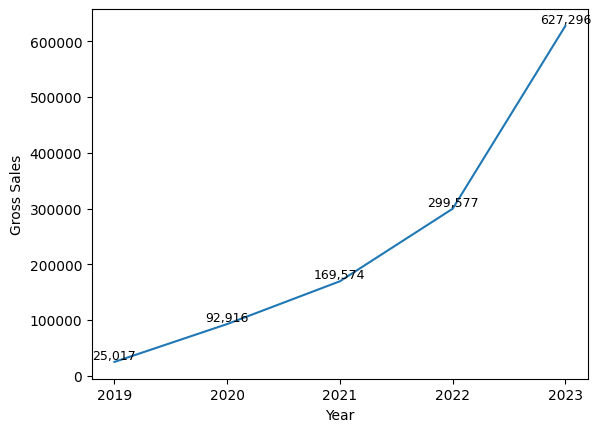

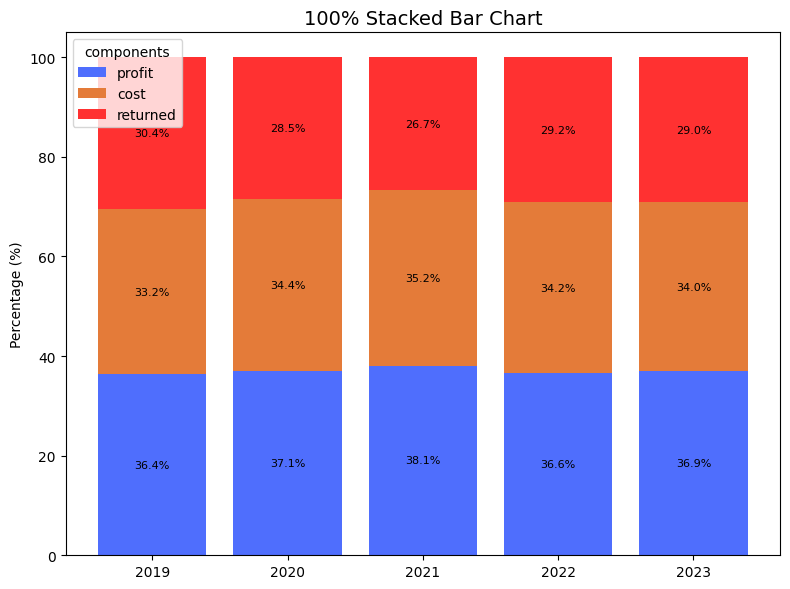

In [34]:
# Visualize Gross Sales Over The Years

df_gross = round(df_total.groupby('year')['sale_price'].sum(), 2).reset_index()

sns.lineplot (data=df_gross, x='year', y='sale_price', markers=True)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Add data label for each year
for x, y in zip(df_gross['year'], df_gross['sale_price']):
    plt.text(x, y, f"{y:,.0f}", ha='center', va='bottom', fontsize=9, color='black')

plt.ylabel('Gross Sales')
plt.xlabel('Year')
plt.show()

# Breakdrown Gross Sales components and visualize
df_profit = round(df_revenue.groupby('year')['profit'].sum(), 2).reset_index()
df_cost = round(df_revenue.groupby('year')['cost'].sum(), 2).reset_index()
df_refund = round(df_returned.groupby('year')['sale_price'].sum(), 2).reset_index().rename(columns={'sale_price':'returned'})

df_components = df_profit.merge(df_cost, left_on='year', right_on='year', how='inner')
df_components = df_components.merge(df_refund, left_on='year', right_on='year', how='inner').set_index('year')

components_percent = df_components.div(df_components.sum(axis=1), axis=0) * 100

# Vẽ stacked bar
fig, ax = plt.subplots(figsize=(8, 6))

bottoms = np.zeros(len(components_percent))
x = np.arange(len(components_percent.index))

color_map = {
    "profit": "#4f6efd",
    "cost": "#e47b39",
    "returned": "#ff3131"
}

for comp in components_percent.columns:
    values = components_percent[comp].values
    bars = ax.bar(x, values, bottom=bottoms, label=comp, color=color_map.get(comp, "#999999"))

    # Add label % vào từng stack
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f"{val:.1f}%", ha="center", va="center", fontsize=8
            )

    bottoms += values

# Xticks nằm chính giữa
ax.set_xticks(x)
ax.set_xticklabels(components_percent.index)

# Format
ax.set_title("100% Stacked Bar Chart", fontsize=14)
ax.set_ylabel("Percentage (%)")
ax.legend(title="components")

plt.tight_layout()
plt.show()

### Quarterly Sales Trend

Examine TheLook China’s quarterly net revenue (2019–2023) to uncover seasonality trends, highlighting peak and off-peak quarters. These insights guide strategic decisions on promotion timing, inventory allocation, and workforce planning.

In [35]:
# Quarterly Net Sales by Years

df_quarterly = round(df_revenue.groupby(['year', 'quarter'])['sale_price'].sum(), 1).reset_index()
df_quarterly_pivot = df_quarterly.pivot(values='sale_price', index='year', columns='quarter')
df_quarterly_pivot['total'] = df_quarterly_pivot[1] + df_quarterly_pivot[2] + df_quarterly_pivot[3] + df_quarterly_pivot[4]
df_quarterly_pivot


quarter,1,2,3,4,total
year,,,,,
2019,179.4,3747.5,6462.4,7010.8,17400.1
2020,11294.8,15048.3,17359.4,22688.9,66391.4
2021,25959.4,28293.1,28914.9,41152.8,124320.2
2022,39719.0,48806.5,57640.3,66072.5,212238.3
2023,77680.3,94769.3,118414.0,154339.2,445202.8


### Weekly Sales Trend

Analyze TheLook China’s weekly net sales trends across years and customer age groups. This tactical perspective highlights key revenue drivers and supports short-term decisions on promotions, staffing, and inventory planning.

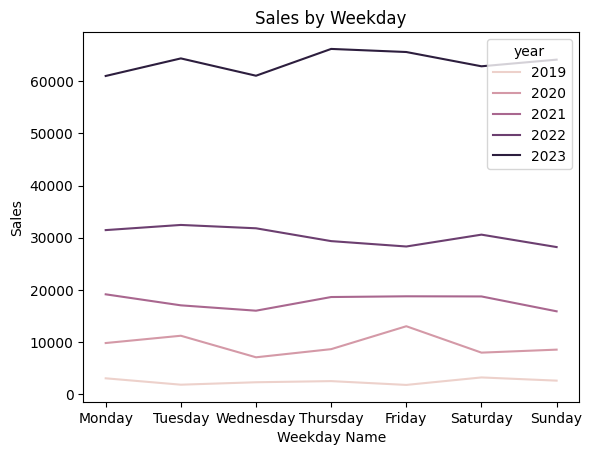

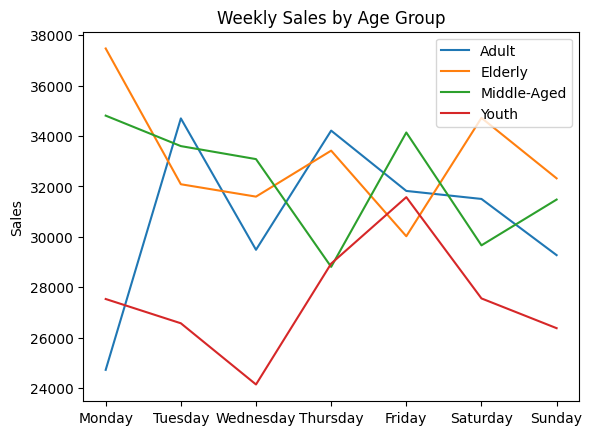

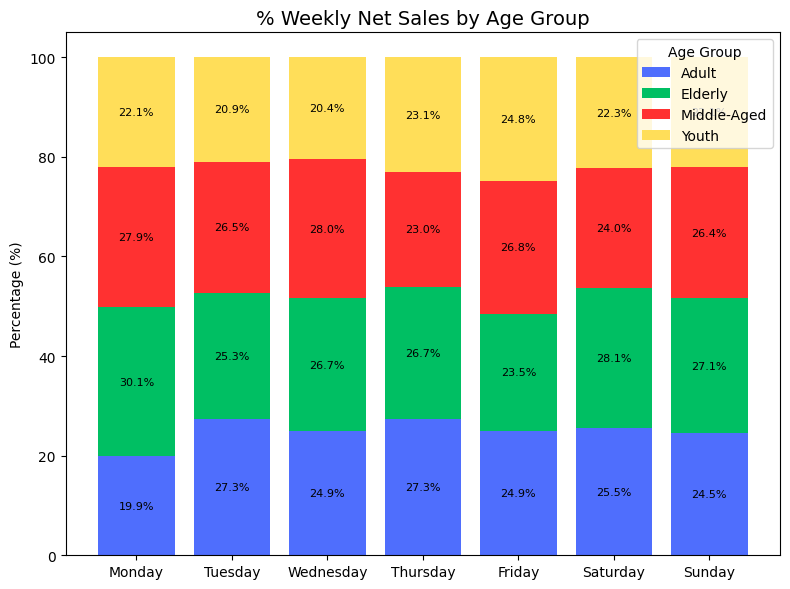

In [36]:
# Sales by Weekday
df_weekday = round(df_revenue.groupby(['year', 'weekday_name', 'weekday_num'])['sale_price'].sum(), 2).reset_index().sort_values(['year','weekday_num'])

w = sns.lineplot(data=df_weekday, x='weekday_name', y='sale_price', hue='year')
plt.xlabel('Weekday Name')
plt.ylabel('Sales')
w.set_title('Sales by Weekday')
plt.show()

# Weekly Sales by Age Group
df_agegroup = round(df_revenue.groupby(['age_group', 'weekday_name', 'weekday_num'])['sale_price'].sum(), 2).reset_index().sort_values(['weekday_num'])

a = sns.lineplot(data=df_agegroup, x='weekday_name', y='sale_price', hue='age_group')
plt.xlabel(None)
plt.ylabel('Sales')
a.set_title('Weekly Sales by Age Group')
plt.legend(loc='upper right')
plt.show()

df_agegroup_pivot = df_agegroup.pivot(values = 'sale_price', index=['weekday_num', 'weekday_name'], columns='age_group').droplevel('weekday_num')

df_agegroup_pivot["Total"] = df_agegroup_pivot['Adult'] + df_agegroup_pivot['Elderly'] + df_agegroup_pivot['Middle-Aged'] + df_agegroup_pivot['Youth']
df_agegroup_pivot['Adult'] = df_agegroup_pivot['Adult']/df_agegroup_pivot['Total']
df_agegroup_pivot['Youth'] = df_agegroup_pivot['Youth']/df_agegroup_pivot['Total']
df_agegroup_pivot['Middle-Aged'] = df_agegroup_pivot['Middle-Aged']/df_agegroup_pivot['Total']
df_agegroup_pivot['Elderly'] = df_agegroup_pivot['Elderly']/df_agegroup_pivot['Total']
df_agegroup_pivot = df_agegroup_pivot.drop(columns='Total')

df_agegroup_percent = round(df_agegroup_pivot * 100, 2)


# Vẽ stacked bar
fig, ax = plt.subplots(figsize=(8, 6))

bottoms = np.zeros(len(df_agegroup_percent))
x = np.arange(len(df_agegroup_percent.index))

color_map = {
    "Elderly": "#00bf63",
    "Adult": "#4f6efd",
    "Middle-Aged": "#ff3131",
    "Youth": "#ffde59"
}

for comp in df_agegroup_percent.columns:
    values = df_agegroup_percent[comp].values
    bars = ax.bar(x, values, bottom=bottoms, label=comp, color=color_map.get(comp, "#999999"))

    # Add label % vào từng stack
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f"{val:.1f}%", ha="center", va="center", fontsize=8
            )

    bottoms += values

# Xticks nằm chính giữa
ax.set_xticks(x)
ax.set_xticklabels(df_agegroup_percent.index)

# Format
ax.set_title("% Weekly Net Sales by Age Group", fontsize=14)
ax.set_ylabel("Percentage (%)")
ax.legend(title="Age Group")

plt.tight_layout()
plt.show()


## Product Analysis

### Sales Trend by Category Group (Net)

An aggregate view of The Look China’s net sales, highlighting the key category groups driving revenue for stakeholders.

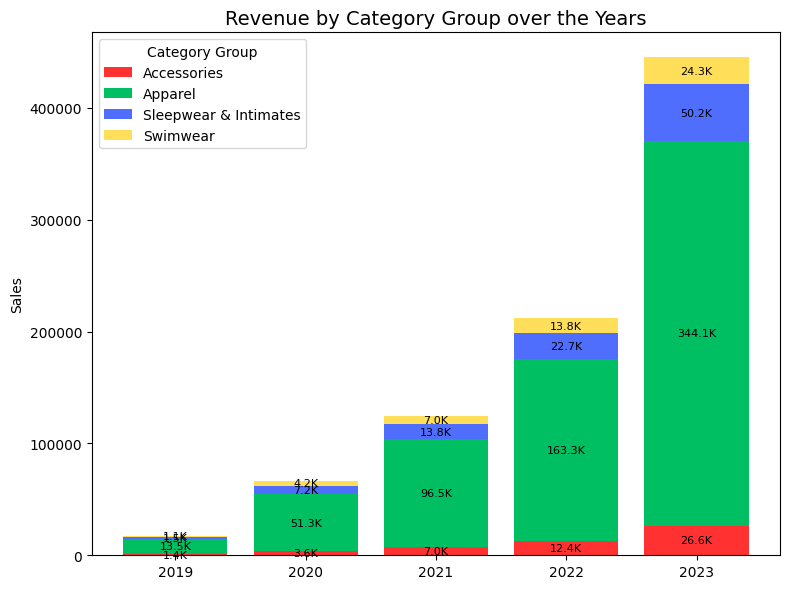

In [37]:
# Sales by Category Group over the Years

df_catgroup = round(df_revenue.groupby(['category_group', 'year'])['sale_price'].sum(), 2).reset_index()
df_catgroup_pivot = df_catgroup.pivot(values='sale_price', index='year', columns = 'category_group')

# Vẽ stacked bar
fig, ax = plt.subplots(figsize=(8, 6))

bottoms = np.zeros(len(df_catgroup_pivot))
x = np.arange(len(df_catgroup_pivot.index))

color_map = {
    "Apparel": "#00bf63",
    "Sleepwear & Intimates": "#4f6efd",
    "Accessories": "#ff3131",
    "Swimwear": "#ffde59"
}

for comp in df_catgroup_pivot.columns:
    values = df_catgroup_pivot[comp].values
    bars = ax.bar(x, values, bottom=bottoms, label=comp, color=color_map.get(comp, "#999999"))

    # Add label % vào từng stack
    for bar, val in zip(bars, values):
        if val > 0:
            ax.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_y() + bar.get_height()/2,
                f"{val/1000:.1f}K", ha="center", va="center", fontsize=8
            )

    bottoms += values

# Xticks nằm chính giữa
ax.set_xticks(x)
ax.set_xticklabels(df_catgroup_pivot.index)

# Format
ax.set_title("Revenue by Category Group over the Years", fontsize=14)
ax.set_ylabel("Sales")
ax.legend(title="Category Group")

plt.tight_layout()
plt.show()


### Product Category Summary

A detailed summary of product categories across key metrics—Net Sales, Profit Margin, Return Rate, Cumulative Revenue Contribution, and CAGR (Compound Annual Growth Rate). This holistic view highlights the categories driving 80% of total revenue and uncovers both growth leaders and underperforming segments.

***Note***: *To summarize the business’s multi-year growth into a single metric, the Compound Annual Growth Rate (CAGR) is used. CAGR mitigates year-to-year volatility by expressing the effective annual growth rate as if growth had occurred steadily and on a compounding basis.*

In [38]:
# Total Revenue, Profit, and Sales Volume over Time by Category
revenue_by_cat = df_revenue.pivot_table (values = ['sale_price',  'profit', 'id'], index = ['category_group', 'product_category'], columns= 'year', aggfunc = {'sale_price': 'sum', 'profit':'sum', 'id':'count'})

revenue_by_cat = revenue_by_cat.rename(columns = {'sale_price':'sales', 'id':'sales_volume'})

# Lấy danh sách năm
years = [2019, 2020, 2021, 2022, 2023]

# Tính CAGR cho từng product_category
sales = revenue_by_cat["sales"][years]

def compute_cagr(row):
    # tìm năm đầu tiên có số liệu (khác NaN)
    valid_years = row.dropna().index
    if len(valid_years) == 0:
        return np.nan  # không có dữ liệu
    start_year = valid_years[0]   # năm đầu tiên có số liệu
    end_year = 2023

    start_value = row[start_year]
    end_value = row[end_year]

    # Nếu end_value null hoặc start_value = 0 thì không tính được CAGR
    if pd.isna(end_value) or start_value == 0:
        return np.nan

    n = end_year - start_year
    return (end_value / start_value) ** (1/n) - 1

# Áp dụng cho từng dòng (từng product_category)
cagr = sales.apply(compute_cagr, axis=1)
cagr = round(cagr*100, 2).astype(str) +"%"

# Gom lại thành dataframe
cagr = (
    cagr.reset_index()
    .rename(columns={0: "CAGR"})
)

cagr.columns = ["category_group", "product_category", "CAGR"]

# Profit Margin by Category
# Tổng profit & sales của từng product_category qua 5 năm
total_profit = revenue_by_cat["profit"][years].sum(axis=1)
total_sales = revenue_by_cat["sales"][years].sum(axis=1)

total_revenue = round(total_sales/1000, 1).reset_index().rename(columns={0:'revenue'})

# Weighted average profit margin cho cả chu kỳ
revenue_by_cat[("profit_margin", "2019-2023")] = round(total_profit / total_sales * 100, 2).astype(str) + "%"

profit_margin = revenue_by_cat['profit_margin']['2019-2023'].reset_index().rename(columns = {'2019-2023':'profit_margin'})

# returned Rate by Category
returned_volume = df_returned.pivot_table (values = 'id', index = ['category_group', 'product_category'], columns= 'year', aggfunc = 'count').fillna(0).astype(int)
sales_volume_1 = revenue_by_cat['sales_volume'].fillna(0).astype(int)

total_order = returned_volume + sales_volume_1

total_return = returned_volume[years].sum(axis=1)
total_order = total_order[years].sum(axis=1)

returned_volume['return_rate'] = round(total_return/total_order * 100, 2).astype(str) + "%"

returned_rate = returned_volume['return_rate'].reset_index()

# Category Table
category_table = total_revenue.merge(cagr, on=['category_group', 'product_category'], how='inner')
category_table = category_table.merge(profit_margin, on=['category_group', 'product_category'], how='inner')
category_table = category_table.merge(returned_rate, on=['category_group', 'product_category'], how='inner')
category_table = category_table.sort_values('revenue', ascending=False).reset_index(drop=True)
category_table['revenue'] = category_table['revenue'].astype(str) + "K"

category_table["revenue_num"] = (
    category_table["revenue"]
    .replace("K", "", regex=True)
    .astype(float) * 1000
)

# Bước 2: sắp xếp theo revenue giảm dần (nếu muốn giống Pareto chart)
category_table = category_table.sort_values("revenue_num", ascending=False)

# Bước 3: tính % đóng góp
category_table["Contribution"] = category_table["revenue_num"] / category_table["revenue_num"].sum()

# Bước 4: tính lũy tiến
category_table["Contribution (Cumulative)"] = category_table["Contribution"].cumsum()

# Bước 5: format về %
category_table["Contribution"] = (category_table["Contribution"] * 100).round(2).astype(str) + "%"
category_table["Contribution (Cumulative)"] = (category_table["Contribution (Cumulative)"] * 100).round(2).astype(str) + "%"
col_arrange = ['category_group', 'product_category', 'revenue', 'CAGR', 'Contribution (Cumulative)', 'profit_margin', 'return_rate']

category_table = category_table[col_arrange]

category_table

,category_group,product_category,revenue,CAGR,Contribution (Cumulative),profit_margin,return_rate
0,Apparel,Outerwear & Coats,103.9K,117.71%,12.0%,55.7%,29.95%
1,Apparel,Jeans,100.4K,113.7%,23.6%,46.36%,29.28%
2,Apparel,Sweaters,67.6K,115.43%,31.41%,51.84%,28.78%
3,Apparel,Suits & Sport Coats,51.4K,168.21%,37.35%,60.0%,29.55%
4,Apparel,Fashion Hoodies & Sweatshirts,51.0K,129.41%,43.24%,48.02%,27.36%
5,Swimwear,Swim,50.4K,119.24%,49.06%,48.42%,29.48%
6,Apparel,Active,44.4K,147.98%,54.19%,58.16%,28.8%
7,Sleepwear & Intimates,Sleep & Lounge,42.9K,148.9%,59.14%,51.85%,24.92%
8,Apparel,Shorts,40.1K,103.71%,63.77%,50.07%,28.08%
9,Apparel,Tops & Tees,40.0K,155.1%,68.4%,44.1%,26.08%


### Brand Category YoY Comparison

Analyze brand health through sales, profit margin, and growth rate, ranking brands by revenue contribution. This helps identify key drivers as well as declining or volatile brands, guiding strategic brand decisions.

In [39]:
brand_revenue = df_revenue[~df_revenue['brand_grouped'].isin(['Other'])].copy()

# Total Revenue and Profit over Time by Brand
revenue_by_brand = brand_revenue.pivot_table (values = ['sale_price',  'profit', 'id'], index = 'brand_grouped', columns= 'year', aggfunc = {'sale_price': 'sum', 'profit':'sum'})

# Revenue and Profit
revenue = round((revenue_by_brand['sale_price'][[2021,2022,2023]]), 2).reset_index().rename(columns= {2021: 'sales_2021', 2022 : 'sales_2022', 2023: 'sales_2023'})
profit = round((revenue_by_brand['profit'][[2022,2023]]), 2).reset_index().rename(columns= {2022 : 'profit_2022', 2023: 'profit_2023'})

# Growth Rate by Brand
''' Pivot table group by each category and calculate by year.
    Calculate growth rate'''

growth_rate_2022 = round(((revenue_by_brand['sale_price'][2022]-revenue_by_brand['sale_price'][2021])/revenue_by_brand['sale_price'][2021] *100), 2).astype(str) + "%"
growth_rate_2022 = growth_rate_2022.reset_index().rename(columns= {0 : 'growth_rate_2022'})
growth_rate_2023 = round(((revenue_by_brand['sale_price'][2023]-revenue_by_brand['sale_price'][2022])/revenue_by_brand['sale_price'][2022] * 100), 2).astype(str) + "%"
growth_rate_2023 = growth_rate_2023.reset_index().rename(columns= {0 : 'growth_rate_2023'})

# Profit Margin by Brand
profit_margin_2022 = round((revenue_by_brand['profit'][2022]/revenue_by_brand['sale_price'][2022] *100), 2).astype(str) + "%"
profit_margin_2022 = profit_margin_2022.reset_index().rename(columns= {2022 : 'profit_margin_2022'})
profit_margin_2023 = round((revenue_by_brand['profit'][2023]/revenue_by_brand['sale_price'][2023] *100), 2).astype(str) + "%"
profit_margin_2023 = profit_margin_2023.reset_index().rename(columns= {2023 : 'profit_margin_2023'})

# Summary Table
growth_rate = growth_rate_2022.merge(growth_rate_2023, on = 'brand_grouped', how = 'inner')
profit_margin = profit_margin_2022.merge(profit_margin_2023, on = 'brand_grouped', how = 'inner')


brand_table = revenue.merge(growth_rate, on='brand_grouped', how='inner')
brand_table = brand_table.merge(profit_margin, on='brand_grouped', how='inner')
brand_table = brand_table.sort_values(by = ['sales_2023', 'sales_2022'], ascending = False)

# Reorder Summary Table
for year in [2021, 2022, 2023]:
    brand_table[f"rank_{year}"] = brand_table[f"sales_{year}"].rank(method="min", ascending=False, na_option="bottom").astype("Int64")

# Bước 2: Tạo rank_diff cho các năm từ 2022 trở đi
brand_table["rank_diff_2022"] = brand_table["rank_2021"] - brand_table["rank_2022"]
brand_table["rank_diff_2023"] = brand_table["rank_2022"] - brand_table["rank_2023"]

new_order = ['sales_2022', 'growth_rate_2022', 'profit_margin_2022', 'rank_2022', 'rank_diff_2022', 'sales_2023', 'growth_rate_2023', 'profit_margin_2023', 'rank_2023', 'rank_diff_2023']
brand_table = brand_table.set_index('brand_grouped')
brand_table = brand_table[new_order]
brand_table['sales_2022'] = round(brand_table['sales_2022']/1000, 1).astype(str) + "K"
brand_table['sales_2023'] = round(brand_table['sales_2023']/1000, 1).astype(str) + "K"

brand_table.columns = pd.MultiIndex.from_tuples([
    ('2022', 'sales'),
    ('2022', 'growth_rate'),
    ('2022', 'profit_margin'),
    ('2022', 'rank'),
    ('2022', 'rank_diff'),
    ('2023', 'sales'),
    ('2023', 'growth_rate'),
    ('2023', 'profit_margin'),
    ('2023', 'rank'),
    ('2023', 'rank_diff')
])

brand_table = brand_table.head(12)

brand_table

2022                                           2023  \
                  sales growth_rate profit_margin rank rank_diff sales   
brand_grouped                                                            
Diesel             5.0K       85.1%        49.14%    1         1  8.6K   
Calvin Klein       3.4K     114.46%        53.76%    4         4  7.7K   
7 For All Mankind  3.1K      88.83%        49.15%    5         0  7.6K   
True Religion      4.7K     194.53%         46.4%    2         5  6.1K   
Columbia           1.2K      -13.2%        52.37%   33       -22  5.9K   
Carhartt           3.0K      35.83%        52.56%    6        -3  5.3K   
Quiksilver         2.4K      143.8%        46.13%    9        12  5.2K   
Ray-Ban            1.8K       11.4%        58.31%   16       -10  5.1K   
Tommy Hilfiger     3.0K      53.69%        56.28%    7        -3  4.7K   
Orvis              2.1K     117.81%        54.65%   12        11  4.5K   
The North Face     3.6K     219.67%        54.53%    3        12  4.4K   
Volcom             2.6K     165.89%        50.36%    8        14  4.3K   

                                                            
                  growth_rate profit_margin rank rank_diff  
brand_grouped                                               
Diesel                 72.47%        48.99%    1         0  
Calvin Klein          128.54%        51.76%    2         2  
7 For All Mankind     147.03%        48.53%    3         2  
True Religion          30.33%        48.36%    4        -2  
Columbia              400.96%        54.45%    5        28  
Carhartt                75.1%        52.96%    6         0  
Quiksilver            113.38%        46.09%    7         2  
Ray-Ban               181.63%        58.21%    8         8  
Tommy Hilfiger         58.99%        55.49%    9        -2  
Orvis                 114.12%        53.26%   10         2  
The North Face         23.53%        56.01%   11        -8  
Volcom                 68.72%        50.07%   12        -4

## Customer Analysis

### Customer Profile

Provide a demographic snapshot of TheLook China’s customer base, highlighting key characteristics such as age, gender, and location.

In [40]:
categorical_dims = ['gender', 'age_group',
                    'traffic_source','state']

# Pie Charts for Categorical Dims
fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'pie'}]*4]*1, subplot_titles=categorical_dims)
for i, col in enumerate(categorical_dims, 1):
    if col in df_sale[['gender', 'age_group','traffic_source','state']]:
        value_counts = df_sale.groupby([col])['user_id'].nunique()
        values = value_counts.values
        labels = value_counts.index
        total = values.sum()

        filtered_labels = []
        filtered_values = []
        other_value = 0

        for label, value in zip(labels, values):
            percent = value / total
            if percent >= 0.035:
                filtered_labels.append(label)
                filtered_values.append(value)
            else:
                other_value += value

        if other_value > 0:
            filtered_labels.append('Other')
            filtered_values.append(other_value)

        fig.add_trace(
            go.Pie(labels=filtered_labels,
                values=filtered_values,
                name=col,),
            row=(i-1)//4 + 1,
            col=(i-1)%4 + 1
        )
fig.update_layout(title_text="Customer Profile", title_x=0.5, height=600)
fig.show()

### RFM Analysis

---

Perform customer behavior–based segmentation to categorize customers into meaningful business groups and define suitable engagement strategies.

K | Inertia | Silhouette
2 | 16802 | 0.533
3 | 10937 | 0.417
4 | 7244 | 0.413
5 | 6142 | 0.393
6 | 5233 | 0.365
7 | 4571 | 0.381
8 | 4164 | 0.378


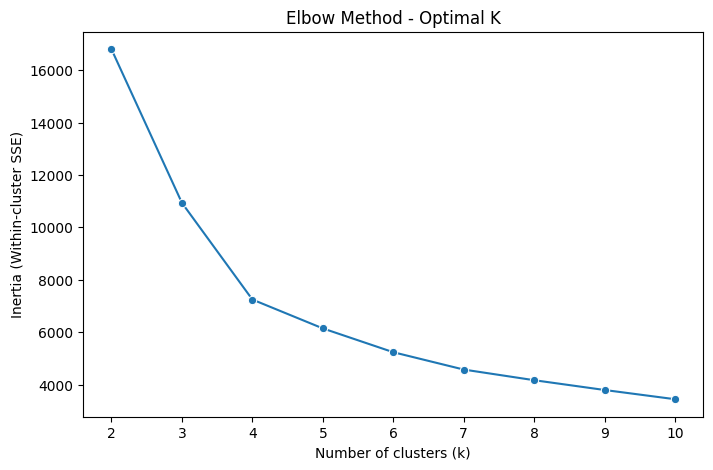


=== Cluster Profiling ===
         customers   R_mean  F_mean  M_mean    revenue
cluster                                               
0             1007   307.21    2.09  189.16  190481.01
1             2639   287.84    1.00  161.00  424872.03
2             1948  1054.43    1.00   75.83  147714.25
3             3167   272.12    1.00   32.36  102485.39


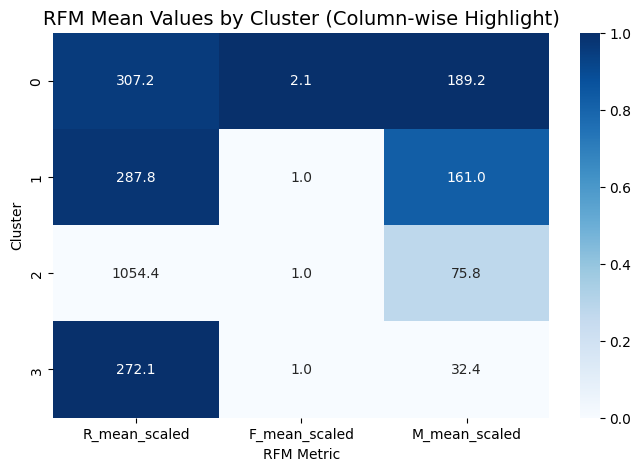

   cluster          segment
0        0      At-risk VIP
1        1        Potential
2        2      Hibernating
3        3  Price Sensitive

Saved user-level RFM segmentation to rfm_clusters.csv


In [56]:
# --- 1. Chuẩn bị dữ liệu ---
df = df_revenue.copy()

# Lấy ngày order (UTC → naive datetime)
df['order_date'] = pd.to_datetime(df['order_created_at'], utc=True, errors='coerce').dt.tz_convert(None)

# Gom từ item-level -> order-level (mỗi order_id chỉ 1 dòng)
order_values = (df.groupby(['user_id','order_id'], as_index=False)
            .agg(order_date=('order_date','max'),
                 order_value=('sale_price','sum')))

# Loại đơn giá trị <= 0 (nếu có lỗi/return)
order_values = order_values[order_values['order_value'] > 0]

# --- 2. Tính RFM cho mỗi khách ---
snapshot_date = order_values['order_date'].max() + pd.Timedelta(days=1)

rfm = (order_values.groupby('user_id')
             .agg(
                  last_order_date=('order_date','max'),
                  F=('order_id','nunique'),           # Frequency = số đơn
                  M=('order_value','sum')             # Monetary = tổng doanh thu
             )
             .reset_index())

rfm['R'] = (snapshot_date - rfm['last_order_date']).dt.days.astype(int)
rfm = rfm[['user_id','R','F','M']]

# --- 3. Biến đổi dữ liệu cho ML ---
rfm_ml = rfm.copy()
rfm_ml['R_pos'] = -rfm_ml['R']          # Đảo dấu để "cao = tốt"
rfm_ml['F_log'] = np.log1p(rfm_ml['F']) # log1p để giảm skew
rfm_ml['M_log'] = np.log1p(rfm_ml['M'])

X = rfm_ml[['R_pos','F_log','M_log']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Chọn số cụm ---
scores = []
for k in range(2,9):
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    scores.append((k, km.inertia_, sil))

print("K | Inertia | Silhouette")
for k, inertia, sil in scores:
    print(f"{k} | {inertia:.0f} | {sil:.3f}")

# => xem output, chọn K phù hợp (ví dụ K=5)
inertias = []
K_range = range(2, 11)  # thử từ 2 -> 10 cụm

for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    km.fit(X_scaled)  # X_scaled là dữ liệu RFM sau chuẩn hóa
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
sns.lineplot(x=list(K_range), y=inertias, marker="o")
plt.title("Elbow Method - Optimal K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.xticks(K_range)
plt.show()

# --- 5. Fit KMeans ---
K = 4
kmeans = KMeans(n_clusters=K, n_init=50, random_state=42)
rfm['cluster'] = kmeans.fit_predict(X_scaled)

# --- 6. Profiling cụm ---
profile = round((rfm.groupby('cluster')
                 .agg(customers=('user_id','nunique'),
                      R_mean=('R','mean'),
                      F_mean=('F','mean'),
                      M_mean=('M','mean'),
                      revenue=('M','sum'))
                 .sort_values('M_mean', ascending=False).reset_index()), 2)

print("\n=== Cluster Profiling ===")
profile = profile.set_index('cluster')
print(profile)

rfm_norm = profile[['R_mean','F_mean','M_mean']].reset_index()

for col in ['R_mean','F_mean','M_mean']:
    col_min, col_max = rfm_norm[col].min(), rfm_norm[col].max()
    if col == 'R_mean':
        # đảo màu cho Recency (càng lớn -> càng nhạt)
        rfm_norm[col+'_scaled'] = 1 - (rfm_norm[col] - col_min) / (col_max - col_min)
    else:
        rfm_norm[col+'_scaled'] = (rfm_norm[col] - col_min) / (col_max - col_min)

# --- Chuẩn bị matrix để vẽ ---
rfm_matrix = rfm_norm.set_index('cluster')[['R_mean_scaled','F_mean_scaled','M_mean_scaled']]

# --- Vẽ heatmap ---
plt.figure(figsize=(8,5))
sns.heatmap(rfm_matrix, annot=profile[['R_mean','F_mean','M_mean']],
            fmt=".1f", cmap="Blues", cbar=True)

plt.title("RFM Mean Values by Cluster (Column-wise Highlight)", fontsize=14)
plt.ylabel("Cluster")
plt.xlabel("RFM Metric")
plt.show()

# --- 7. Xuất kết quả ---
print(pd.DataFrame({'cluster':profile.index.tolist(), 'segment':['At-risk VIP', 'Potential', 'Hibernating', 'Price Sensitive']}))
rfm.to_csv("rfm_clusters.csv", index=False)
print("\nSaved user-level RFM segmentation to rfm_clusters.csv")

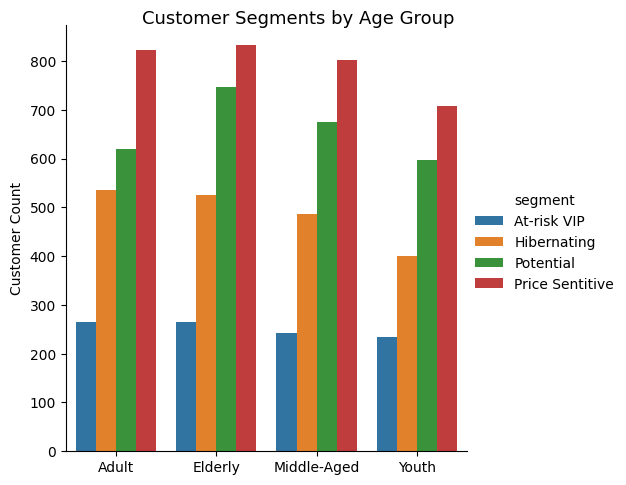

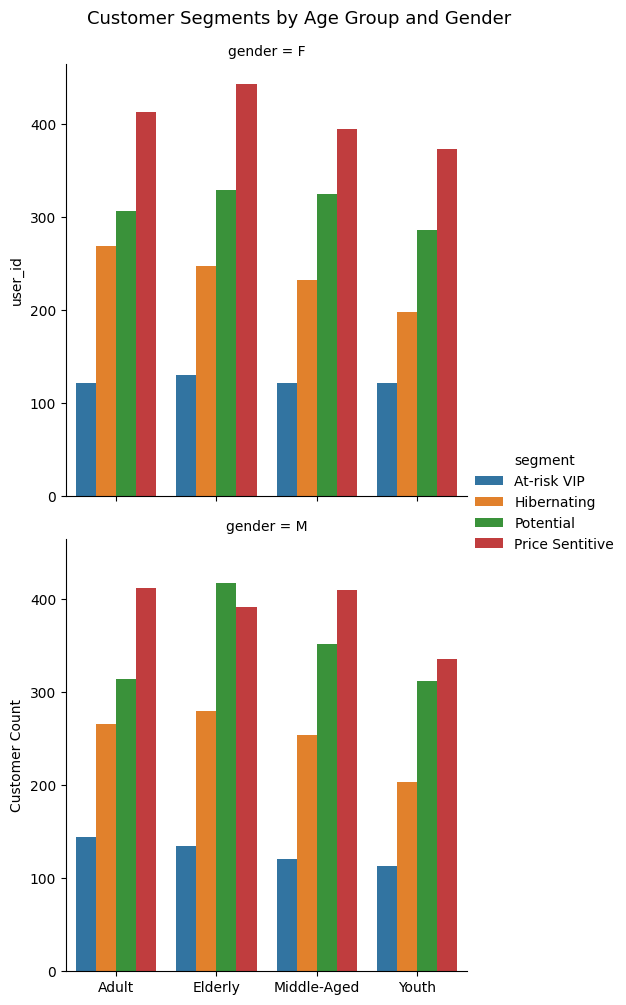

In [92]:
# Create a new DataFrame named df_rfm to conduct customer segmentation
conditions = [
    (rfm['cluster'] == 0),
     (rfm['cluster'] == 1),
     (rfm['cluster'] == 2),
     (rfm['cluster'] == 3)
]

choices = ['At-risk VIP', 'Potential', 'Hibernating', 'Price Sentitive']

rfm['segment'] = np.select(conditions, choices, default='Other')

df_rfm = rfm.merge(users[['id', 'age_group', 'gender']], left_on = 'user_id', right_on='id', how='inner').drop(columns=['R', 'F', 'M', 'cluster', 'id'])

# Visualize Customer Segments by Age Group
df_rfm_general = df_rfm.groupby(['segment', 'age_group']).nunique().reset_index()

rfm_bar = sns.catplot (data = df_rfm_general, x='age_group', y='user_id', hue='segment', kind='bar')
rfm_bar.fig.suptitle('Customer Segments by Age Group', y=1, fontsize = 13)
plt.xlabel(None)
plt.ylabel('Customer Count')
plt.show()

# More detail with Customer Segments by both Age Group and Gender

df_rfm_detailed = df_rfm.groupby(['segment', 'age_group', 'gender']).nunique().reset_index()
rfm_sub = sns.catplot (data = df_rfm_detailed, x='age_group', y='user_id', hue='segment', row='gender', kind='bar')
rfm_sub.fig.suptitle('Customer Segments by Age Group and Gender', y=1.02, fontsize = 13)
plt.xlabel(None)
plt.ylabel('Customer Count')
plt.show()

### Market Basket Analysis

Conduct Market Basket Analysis (MBA) to identify product bundles and cross-sell opportunities, enhancing product recommendations and driving higher Average Order Value (AOV).

/tmp/ipython-input-2412882871.py:10: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Top 20 rules by lift:


,antecedents,consequents,support,confidence,lift
93,"(Blazers & Jackets,)","(Maternity,)",0.001736,0.068548,1.848918
92,"(Maternity,)","(Blazers & Jackets,)",0.001736,0.046832,1.848918
348,"(Suits & Sport Coats,)","(Socks,)",0.003575,0.092105,1.782219
349,"(Socks,)","(Suits & Sport Coats,)",0.003575,0.069170,1.782219
90,"(Leggings,)","(Blazers & Jackets,)",0.001123,0.043137,1.703052
91,"(Blazers & Jackets,)","(Leggings,)",0.001123,0.044355,1.703052
122,"(Skirts,)","(Dresses,)",0.001226,0.069767,1.622549
123,"(Dresses,)","(Skirts,)",0.001226,0.028504,1.622549
297,"(Plus,)","(Pants & Capris,)",0.001532,0.044248,1.616530
296,"(Pants & Capris,)","(Plus,)",0.001532,0.055970,1.616530


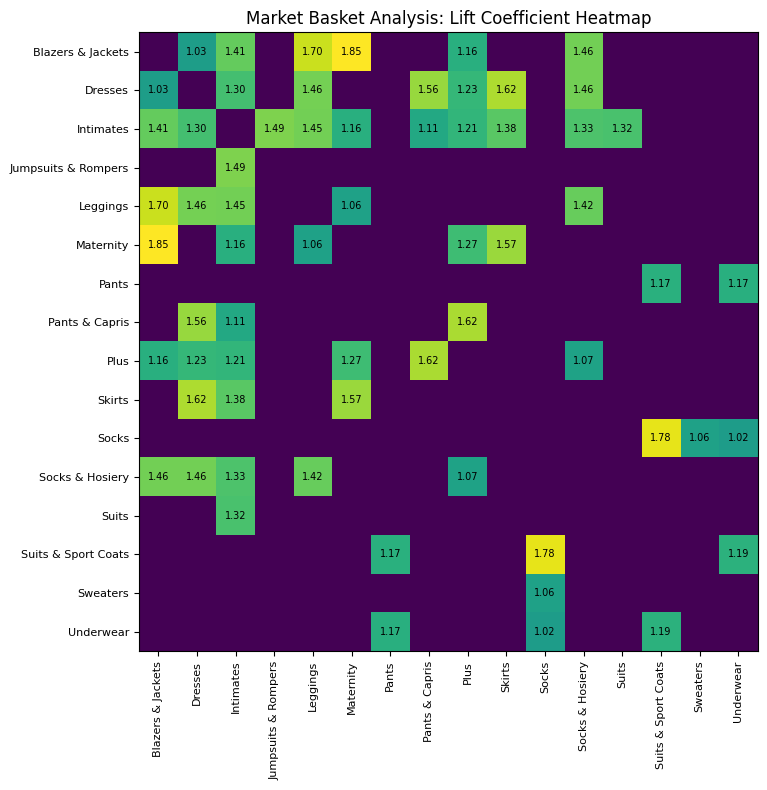

In [93]:
#MARKET BASKET ANALYSIS

# ---------- 1. Chuẩn bị dữ liệu ----------
# Giả sử df_revenue đã là dataframe bạn mô tả (status='Complete', 2019-2023, China)
# và có cột: id (transaction id), order_id, product_name, quantity (nếu có)

# Nếu bạn có cột 'quantity' dùng quantity, nếu không, count occurrences.
# Dưới đây dùng count -> chuyển thành binary (0/1 per transaction per product)

df_revenue['order_month'] = df_revenue['order_created_at'].dt.to_period('M')
basket = df_revenue.groupby(['user_id', 'order_month', 'product_category']).size().unstack(fill_value=0)

# Chuyển về binary (1 nếu item có trong transaction, 0 otherwise)
basket = basket.map(lambda x: 1 if x > 0 else 0)

# Nếu muốn loại bỏ sản phẩm quá hiếm (ví dụ xuất hiện < thresh_trans transactions), có thể filter columns:
min_txn_count = 2  # ví dụ: loại sản phẩm quá hiếm
col_counts = basket.sum(axis=0)
keep_cols = col_counts[col_counts >= min_txn_count].index
basket = basket[keep_cols]

# ---------- 2. Apriori: tìm frequent itemsets (2 và 3) ----------
min_support = 0.001   # bạn có thể điều chỉnh: 0.001 = 0.1% transactions
frequent_itemsets = apriori(basket, min_support=min_support, use_colnames=True, max_len=3)

# tách itemsets theo độ dài (optional)
freq_1 = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 1].copy()
freq_2 = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 2].copy()
freq_3 = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 3].copy()

# ---------- 3. Association rules ----------
# Sinh rules từ frequent_itemsets; mặc định metric='confidence' hoặc 'lift' tuỳ ý.
min_confidence = 0.01
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Lọc rules hữu ích (ví dụ: min_lift)
min_lift = 1.0
rules = rules[rules['lift'] >= min_lift].sort_values(by=['lift','confidence'], ascending=[False,False])

# Format: antecedents, consequents -> as tuple of strings
rules['antecedents'] = rules['antecedents'].apply(lambda s: tuple(s))
rules['consequents'] = rules['consequents'].apply(lambda s: tuple(s))

# ---------- 4. Lấy top associations (ví dụ top 20 by lift) ----------
top_rules = rules.sort_values(by='lift', ascending=False).head(20)
print("Top 20 rules by lift:")
display(top_rules[['antecedents','consequents','support','confidence','lift']])

# ---------- 5. Heatmap Lift cho cặp sản phẩm (pairs only) ----------
# Lấy rules với antecedent size==1 and consequent size==1
pair_rules = rules[(rules['antecedents'].apply(len) == 1) & (rules['consequents'].apply(len) == 1)].copy()

# Tạo danh sách items (các product phổ biến)
items = sorted(list(set([list(x)[0] for x in pair_rules['antecedents']] + [list(x)[0] for x in pair_rules['consequents']])))

# Tạo ma trận lift (items x items)
lift_matrix = pd.DataFrame(np.nan, index=items, columns=items)

for _, row in pair_rules.iterrows():
    a = list(row['antecedents'])[0]
    b = list(row['consequents'])[0]
    lift_matrix.loc[a, b] = row['lift']

# Để heatmap đối xứng (khả năng bạn muốn hiển thị lift cho cả 2 hướng),
# ta có thể lấy max(lift_ab, lift_ba) cho ô (a,b) và (b,a) — tùy bạn.
# Ở đây ta tạo matrix_sym = max(lift, lift.T)
matrix_sym = lift_matrix.copy()
for i in items:
    for j in items:
        v1 = lift_matrix.loc[i, j]
        v2 = lift_matrix.loc[j, i]
        if pd.isna(v1) and pd.isna(v2):
            matrix_sym.loc[i, j] = np.nan
        else:
            # lấy max bỏ NaNs
            vals = [x for x in [v1, v2] if not pd.isna(x)]
            matrix_sym.loc[i, j] = max(vals) if vals else np.nan

# Plot heatmap (matplotlib only; 1 plot)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(matrix_sym.fillna(0).values)  # NaN->0 để vẽ; ta sẽ mask khi annotate

ax.set_xticks(np.arange(len(items)))
ax.set_yticks(np.arange(len(items)))
ax.set_xticklabels(items, rotation=90, fontsize=8)
ax.set_yticklabels(items, fontsize=8)
ax.set_title('Market Basket Analysis: Lift Coefficient Heatmap')

# Annotate values (show lift only if not NaN and > 0)
for i in range(len(items)):
    for j in range(len(items)):
        val = matrix_sym.iloc[i, j]
        if not pd.isna(val) and val > 0:
            txt = f"{val:.2f}"
            ax.text(j, i, txt, ha='center', va='center', fontsize=7)

plt.tight_layout()
plt.show()



### Cohort Retention Analysis

Analyze customer retention by cohorts to evaluate TheLook China’s ability to acquire and retain customers over time. These insights form the basis for strategies to improve loyalty and long-term growth.

/tmp/ipython-input-1092294730.py:10: FutureWarning:

Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.



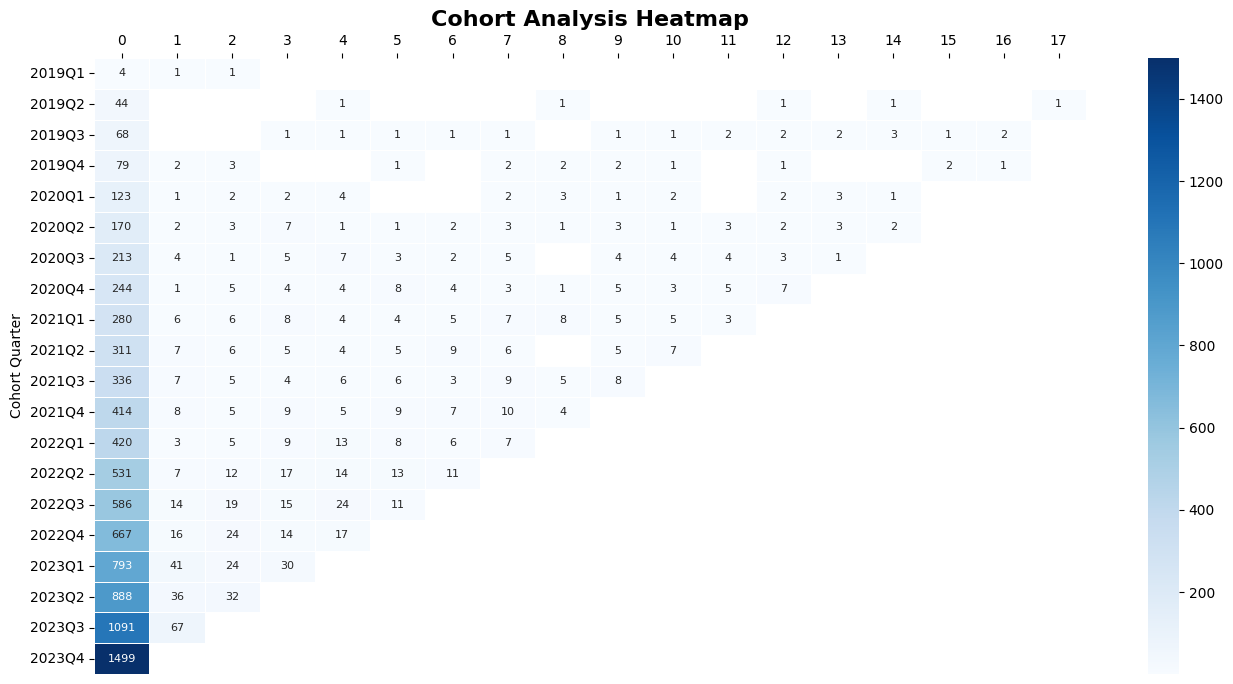

In [44]:
# Cohort chart

df_user_over_time = (
    df_revenue[(df_revenue['year'] >= 2019) & (df_revenue['year'] < 2024)]
    [['user_id', 'year', 'quarter']]
    .drop_duplicates()  # tránh duplicate giao dịch trong cùng 1 quý
)

# --- 2. Tạo cột PeriodIndex cho quý ---
df_user_over_time['date_quarter'] = pd.PeriodIndex(
    year=df_user_over_time['year'],
    quarter=df_user_over_time['quarter'],
    freq='Q'
)

# --- 3. Xác định cohort_quarter ---
first_purchase = df_user_over_time.groupby('user_id')['date_quarter'].min()
df_cohort = df_user_over_time.merge(first_purchase.rename('cohort_quarter'), on='user_id')

# --- 4. Tính period_number ---
def quarter_diff(start, current):
    return (current.year - start.year) * 4 + (current.quarter - start.quarter)

df_cohort['period_number'] = [
    quarter_diff(start, current)
    for start, current in zip(df_cohort['cohort_quarter'], df_cohort['date_quarter'])
]

# --- 5. Pivot cohort table ---
cohort_data = (
    df_cohort.groupby(['cohort_quarter', 'period_number'])['user_id']
      .nunique()
      .unstack(fill_value=0)
      .sort_index()  # sort theo thời gian thực
)

# Tính tổng theo cột (tổng các cohort cho từng period_number)
col_totals = cohort_data.sum(axis=0)
cohort_data.loc["Total"] = col_totals

# Tính tổng theo hàng (tổng theo cohort)
cohort_data["Total"] = cohort_data.sum(axis=1)

# Vẽ heatmap (không bao gồm cột "Total" và hàng "Total")
cohort_heatmap = cohort_data.drop("Total", axis=1).drop("Total", axis=0)

plt.figure(figsize=(16, 8))
# Tạo mask cho các ô có giá trị = 0
mask = (cohort_heatmap == 0)

heat_map = sns.heatmap(
    cohort_heatmap,
    annot=True,
    fmt="g",
    cmap="Blues",
    linewidths=0.5,
    linecolor="white",
    cbar=True,
    mask=mask,  # ẩn màu cho các ô = 0
    annot_kws={"size": 8}
)

# Ẩn text = 0 (cách khác: custom annot)
for text in ax.texts:
    if text.get_text() == "0":
        text.set_text("")

heat_map.xaxis.set_ticks_position('top')
plt.xticks(rotation=0)

plt.title("Cohort Analysis Heatmap", fontsize=16, fontweight="bold")
plt.ylabel("Cohort Quarter")
plt.xlabel(None)

plt.show()


### Returns' impact on Churn Rate

Investigate churn rate trends over time and quantify the share of churn driven by product returns. This reveals whether returns represent a significant risk to The Look China’s business health and indicates if reducing returns should be a strategic priority.


=== COHORT TABLE (per quarter) ===
        customers  churned  churn_rate_%  churn_due_return  %_churn_due_return_of_customers  %_churn_due_return_of_churned
2019Q1         17       10          58.8                 5                             29.4                           50.0
2019Q2         57       42          73.7                 6                             10.5                           14.3
2019Q3         81       58          71.6                12                             14.8                           20.7
2019Q4        115       90          78.3                25                             21.7                           27.8
2020Q1        174      123          70.7                34                             19.5                           27.6
2020Q2        234      183          78.2                46                             19.7                           25.1
2020Q3        298      226          75.8                61                             20.5            

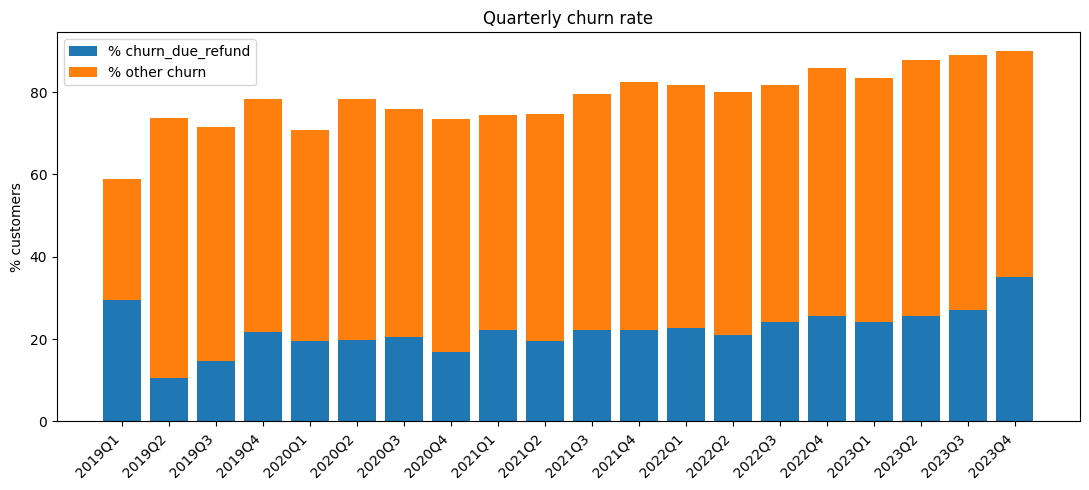

In [45]:
def churn_due_to_return_by_quarter(df, lookback_days=90):
    d = df.copy()

    # chuẩn hóa datetime (tz-aware -> tz-naive)
    for col in ['order_created_at', 'delivered_at', 'returned_at']:
        d[col] = pd.to_datetime(d[col], utc=True, errors='coerce').dt.tz_convert(None)

    # items đã giao (mua thật)
    delivered = d[d['delivered_at'].notna()].copy()
    if delivered.empty:
        raise ValueError("Không có item delivered. Kiểm tra dữ liệu.")

    # tổng hợp theo (user_id, order_id) -- GIỮ order_id là column
    ord_deliv = (delivered
                 .groupby(['user_id','order_id'], as_index=False)
                 .agg(order_created_at=('order_created_at','min'),
                      delivered_items=('id','count')))

    ord_ret = (d[d['returned_at'].notna()]
               .groupby(['user_id','order_id'], as_index=False)
               .agg(returned_items=('id','count')))

    ord_sum = (ord_deliv.merge(ord_ret, on=['user_id','order_id'], how='left')
                        .fillna({'returned_items':0}))
    ord_sum['any_return']  = ord_sum['returned_items'] > 0
    ord_sum['full_return'] = ord_sum['returned_items'] >= ord_sum['delivered_items']

    # user-level: số đơn giao + đơn đầu
    orders_delivered = (ord_sum.groupby('user_id', as_index=False)['order_id']
                        .nunique()
                        .rename(columns={'order_id':'orders_delivered'})
                        .set_index('user_id'))

    first_order = (ord_sum.sort_values(['user_id','order_created_at'])
                          .groupby('user_id', as_index=False)
                          .head(1)
                          .set_index('user_id'))

    u = (orders_delivered
         .join(first_order[['order_created_at','any_return','full_return']], how='left')
         .rename(columns={'order_created_at':'first_order_date'}))

    # churn = chỉ có đúng 1 đơn giao
    u['is_churned'] = u['orders_delivered'] == 1

    # cửa sổ quan sát đủ dài
    horizon = delivered['order_created_at'].max()
    u = u[u['first_order_date'] <= (horizon - pd.Timedelta(days=lookback_days))].copy()

    # cohort theo quý của đơn đầu
    u['cohort_q'] = u['first_order_date'].dt.to_period('Q').astype(str)

    # rời bỏ do return (đơn đầu)
    u['churn_due_return']      = u['is_churned'] & u['any_return']
    u['churn_due_full_return'] = u['is_churned'] & u['full_return']

    # tổng hợp theo quý
    out = (u.groupby('cohort_q')
             .agg(
                 customers=('orders_delivered','size'),
                 churned=('is_churned','sum'),
                 churn_due_return=('churn_due_return','sum'),
                 churn_due_full_return=('churn_due_full_return','sum')
             )
             .sort_index())

    # tỷ lệ
    out['churn_rate_%'] = (out['churned'] / out['customers'] * 100).round(1)
    out['%_churn_due_return_of_customers'] = (out['churn_due_return'] / out['customers'] * 100).round(1)
    out['%_churn_due_return_of_churned']   = (out['churn_due_return'] / out['churned'] * 100).round(1)

    # Total theo số đếm (nếu bạn muốn, bỏ 3 dòng dưới)
    total = out.sum(numeric_only=True).to_frame().T
    total.index = ['Total']
    out = pd.concat([out, total], axis=0)

    return out, u


# =========================
# 2) TÍNH & LÀM BẢNG ĐẸP
# =========================
out, users_detail = churn_due_to_return_by_quarter(df_sale, lookback_days=90)

# bỏ hàng Total khi vẽ (để x-axis gọn), vẫn giữ cho export nếu cần
out_plot = out.loc[out.index!='Total'].copy()

# ép kiểu đếm về int cho dễ nhìn
for c in ['customers','churned','churn_due_return','churn_due_full_return']:
    out_plot[c] = out_plot[c].astype(int)

# bảng tóm tắt “dễ đọc”
table = out_plot[['customers','churned','churn_rate_%',
                  'churn_due_return','%_churn_due_return_of_customers',
                  '%_churn_due_return_of_churned']]

print("\n=== COHORT TABLE (per quarter) ===")
print(table.to_string())


# =========================
# 3) BIỂU ĐỒ STACKED BAR:
#    tổng churn = phần do return + phần churn khác
# =========================
out_plot['other_churn_%'] = (out_plot['churn_rate_%'] - out_plot['%_churn_due_return_of_customers']).clip(lower=0)

cohorts = out_plot.index.tolist()
x = np.arange(len(cohorts))

plt.figure(figsize=(11,5))
plt.bar(x, out_plot['%_churn_due_return_of_customers'].values, label='% churn_due_refund')
plt.bar(x, out_plot['other_churn_%'].values, bottom=out_plot['%_churn_due_return_of_customers'].values, label='% other churn')
plt.xticks(x, cohorts, rotation=45, ha='right')
plt.ylabel('% customers')
plt.title('Quarterly churn rate')
plt.legend()
plt.tight_layout()
plt.show()



## Returns Analysis

### Top Sources of Returns

Identify categories or marketplaces that are both top contributors to returns and have above-average return rates (28.26%). This analysis highlights areas that should be prioritized for return rate improvement.

In [46]:
def return_attribution(df, dims, min_items=100):
    d = df.copy()
    for c in ["delivered_at","shipped_at","returned_at"]:
        d[c] = pd.to_datetime(d[c], utc=True, errors="coerce").dt.tz_convert(None)

    # Chỉ xét item đã giao (mua thật)
    d = d[d["delivered_at"].notna()].copy()
    d["is_returned"] = d["returned_at"].notna()

    # Thêm vài metric hữu ích
    d["lead_days"] = (d["delivered_at"] - d["shipped_at"]).dt.days
    d["days_to_return"] = np.where(d["is_returned"],
                                   (d["returned_at"] - d["delivered_at"]).dt.days, np.nan)
    d["margin"] = d["sale_price"] - d["cost"]
    d["returned_revenue"] = np.where(d["is_returned"], d["sale_price"], 0.0)
    d["returned_margin_loss"] = np.where(d["is_returned"], d["margin"], 0.0)

    g = d.groupby(dims, observed=True)
    out = g.agg(
        items=("id","count"),
        returned_items=("is_returned","sum"),
        refund_rate=("is_returned","mean"),
        gross_revenue=("sale_price","sum"),
        returned_revenue=("returned_revenue","sum"),
        returned_margin_loss=("returned_margin_loss","sum"),
        median_lead_days=("lead_days","median"),
        median_days_to_return=("days_to_return","median"),
    ).reset_index()

    # Đóng góp vào tổng refund toàn công ty
    total_returns = out["returned_items"].sum()
    out["return_share_%"] = np.where(total_returns>0,
                                     out["returned_items"]/total_returns*100, 0)
    # Chỉ hiển thị nhóm đủ volume
    out = out[out["items"] >= min_items].copy()

    # Chỉ số ưu tiên: vừa “to” vừa “xấu”
    out["severity_index"] = out["refund_rate"] * out["return_share_%"]
    out["refund_rate_%"] = (out["refund_rate"]*100).round(1)
    out["return_share_%"] = out["return_share_%"].round(1)

    out = out.sort_values(["severity_index","returned_items"], ascending=False)
    return out


In [47]:
def pareto_returns_chart(df, dims, topN=15, min_items=100,
                         rank_by="return_share_%", annotate=True,
                         figsize=(10,6)):
    tbl = return_attribution(df, dims, min_items=min_items)

    # allow ranking by human-readable column names
    rank_col = rank_by
    if rank_by == "refund_rate_%":
        # already present
        pass
    elif rank_by in ("return_share_%","returned_items","severity_index"):
        pass
    else:
        raise ValueError("rank_by must be one of: 'return_share_%', 'refund_rate_%', 'returned_items', 'severity_index'")

    plot_df = tbl.sort_values(rank_col, ascending=False).head(topN).copy()

    # build label: "A × B × C"
    label_cols = [c for c in dims]
    plot_df["label"] = plot_df[label_cols].astype(str).agg(" × ".join, axis=1)

    # choose the metric we show on the X axis: for Pareto we default to share (%)
    x_values = plot_df["return_share_%"].values
    y_pos = np.arange(len(plot_df))[::-1]  # top at top

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y_pos, x_values)  # default colors/style
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df["label"].tolist())
    ax.set_xlabel("Return share (%)")
    title_dims = " × ".join(dims)
    ax.set_title(f"Top sources of returns — {title_dims} (share of total returned items)")

    if annotate:
        # annotate at bar ends
        for i, v in enumerate(x_values[::-1]):
            ax.text(v + 0.3, i, f"{v:.1f}%", va="center", fontsize=9)

    plt.tight_layout()
    return fig, ax, plot_df

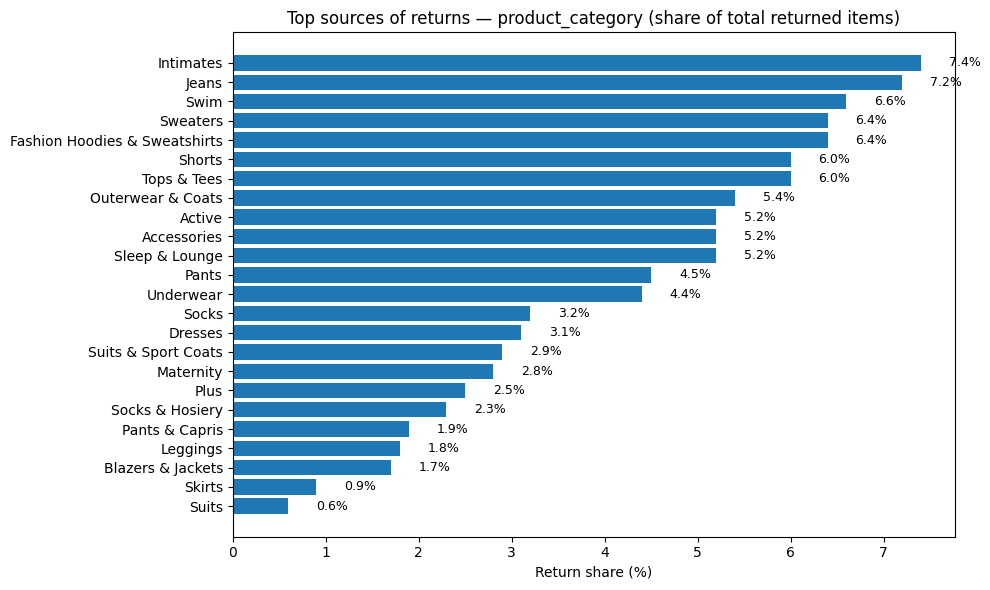

In [48]:
_, _, top_tbl = pareto_returns_chart(df_sale, ['product_category'],topN=25)

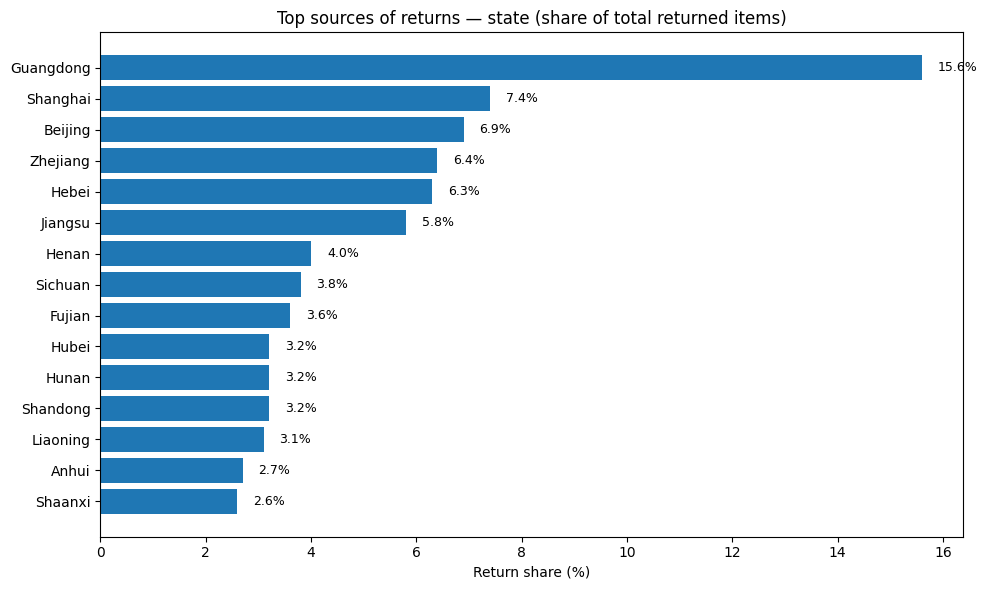

In [49]:
_, _, top_tbl = pareto_returns_chart(df_sale, ['state'])

### Delivery Time & Returns Correlation

Analyze the impact of delivery times on return behavior to determine whether faster deliveries can help reduce the return rate.

In [50]:
# Setting up dataframe and metrics
df_delivery = df_total[['order_id', 'user_id', 'status', 'state', 'order_created_at', 'delivered_at']]

df_delivery = df_delivery.drop_duplicates()
df_delivery['delivery_time'] = df_delivery['delivered_at'] - df_delivery['order_created_at']

/tmp/ipython-input-1520472090.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




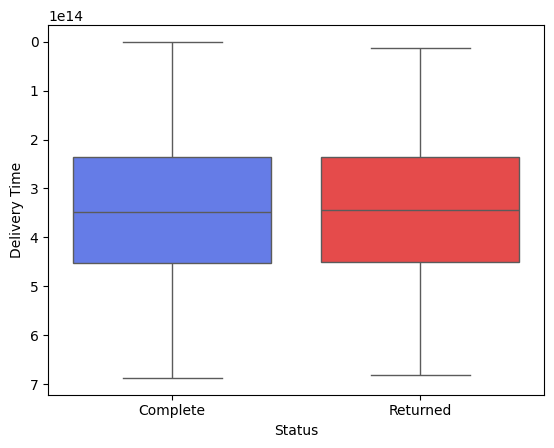

In [51]:
# Delivery time comparison between "Returned" orders and "Completed" orders

sns.boxplot(x='status', y = 'delivery_time', palette = {'Complete' : '#4f6efd', 'Returned' : '#ff3131'}, data=df_delivery)
plt.ylabel('Delivery Time')
plt.xlabel('Status')
plt.show()

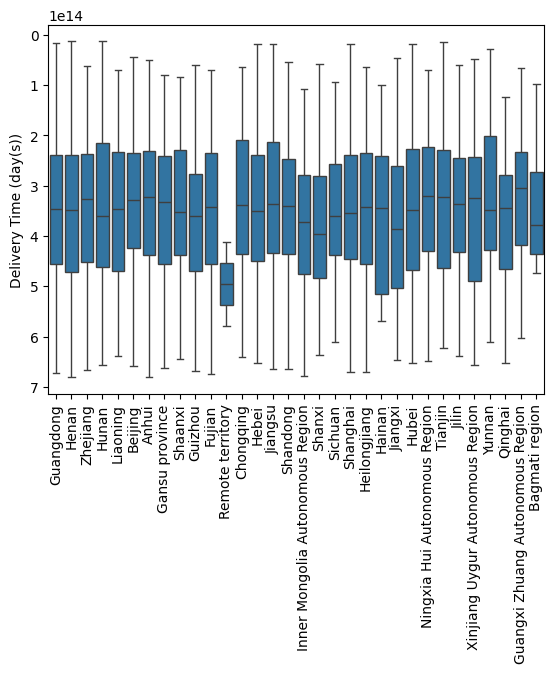


 Order Return Rate and Delivery Time by State 
                                state  order_returned_rate  delivery_time
0                              Anhui                28.01           3.84
1                     Bagmati region                31.58           3.84
2                            Beijing                29.67           3.83
3                          Chongqing                32.48           3.75
4                             Fujian                27.43           4.00
5                     Gansu province                27.10           3.98
6                          Guangdong                28.90           4.03
7   Guangxi Zhuang Autonomous Region                28.21           3.77
8                            Guizhou                29.06           4.17
9                             Hainan                23.46           4.22
10                             Hebei                28.20           4.01
11                      Heilongjiang                29.65           3.99
12

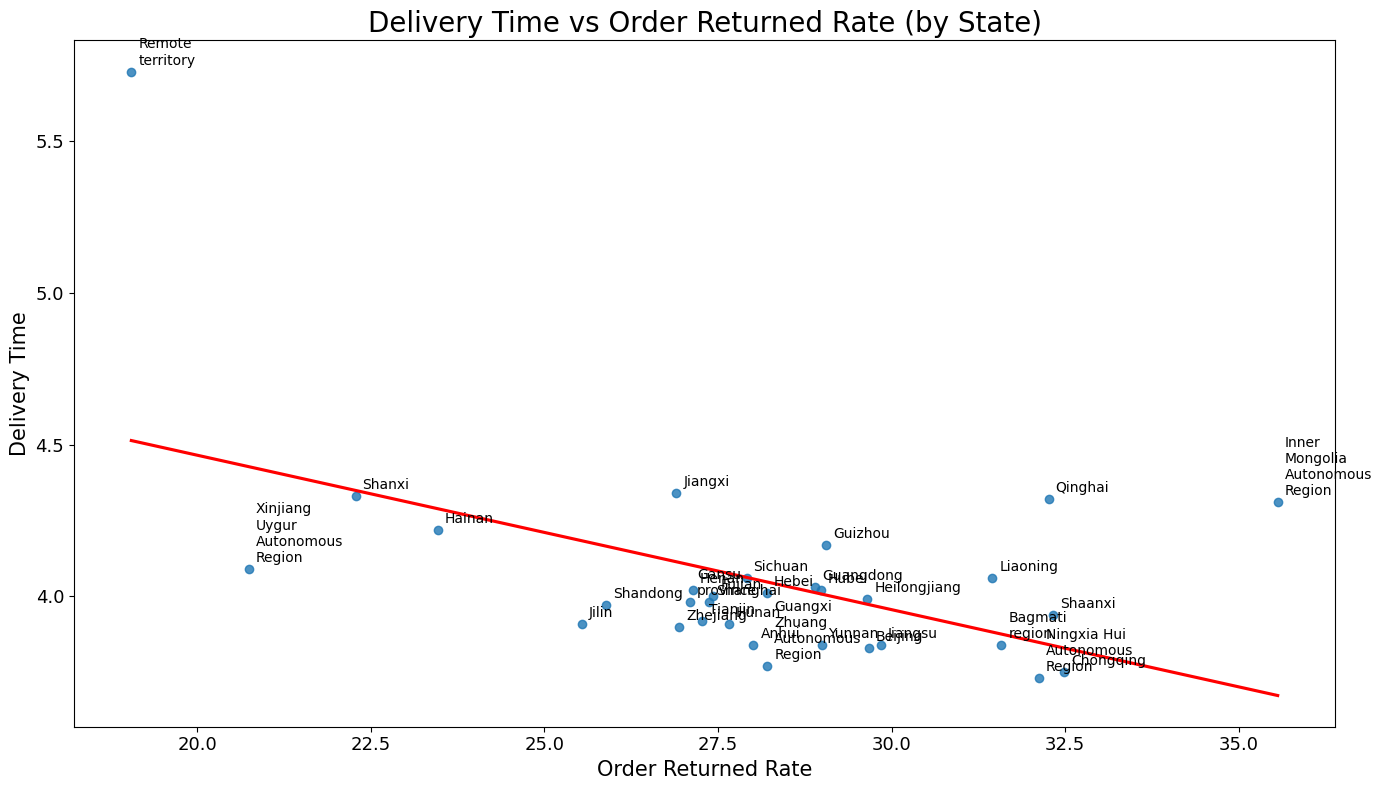


 Correlation between Order Return Rate and Delivery Time 
                      order_returned_rate  delivery_time
order_returned_rate             1.000000      -0.503556
delivery_time                  -0.503556       1.000000


In [52]:
# Delivery time comparison between different states

sns.boxplot(x='state', y = 'delivery_time', data=df_delivery[df_delivery['status'] == 'Returned'])
plt.xticks(rotation = 90)
plt.xlabel(None)
plt.ylabel('Delivery Time (day(s))')
plt.show()

returned_by_state = round(df_returned['state'].value_counts() / df_total['state'].value_counts() * 100, 2)
returned_by_state = returned_by_state.reset_index().rename(columns = {'count':'order_returned_rate'})

delivery_by_state = df_delivery[df_delivery['status'] == 'Returned'].groupby('state')['delivery_time'].mean()
delivery_by_state = round(delivery_by_state / pd.Timedelta(days=1), 2)
delivery_by_state = delivery_by_state.reset_index()

df_deli_compare = returned_by_state.merge(delivery_by_state, left_on = 'state', right_on = 'state', how ='inner')
deli_compare = df_deli_compare.set_index('state').corr()

print('\n Order Return Rate and Delivery Time by State \n' , df_deli_compare)

fig, ax = plt.subplots(figsize=(14,8))

# Scatter + regression line
sns.regplot(
    data=df_deli_compare,
    x="order_returned_rate",
    y="delivery_time",
    scatter=True,
    ax=ax,
    ci=None,
    line_kws={"color":"red"}  # màu đường hồi quy
)

# Gắn nhãn state

for i, row in df_deli_compare.iterrows():
    label = "\n".join(textwrap.wrap(row["state"], width=13))  # wrap mỗi 15 ký tự
    ax.annotate(
        label,
        (row["order_returned_rate"], row["delivery_time"]),
        xytext=(5, 5), textcoords="offset points", fontsize=10
    )

plt.xlabel("Order Returned Rate", fontsize=15)
plt.ylabel("Delivery Time", fontsize=15)
plt.title("Delivery Time vs Order Returned Rate (by State)", fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.show()
print('\n Correlation between Order Return Rate and Delivery Time \n', deli_compare)

In [53]:
print(df_deli_compare.head())
print(df_deli_compare.columns)

            state  order_returned_rate  delivery_time
0           Anhui                28.01           3.84
1  Bagmati region                31.58           3.84
2         Beijing                29.67           3.83
3       Chongqing                32.48           3.75
4          Fujian                27.43           4.00
Index(['state', 'order_returned_rate', 'delivery_time'], dtype='object')


# V. Conclusion

See the README.md file for a detailed conclusion.